In [1]:
#!pip install  meteva
import os,sys
import datetime as dt
import xarray as xr
import time
from datetime import datetime
import numpy as np
# np.set_printoptions(threshold=np.inf)
import seaborn as sns
import pandas as pd
import glob as glob
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as pl
import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# import meteva.base as meb      # 该模块用于IO和基础计算
# import meteva.method as mem    # 该模块基础了检验的基础算法
# import meteva.product as mpd   # 该模块包含了检验的工具      
import copy
#from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
import torch
sys.path.append("/p/home/jusers/gong1/juwels/.local/lib/python3.10/site-packages/")
import meteva.base as meb      
import meteva.method as mem   
import meteva.product as mpd   
import numpy as np          
import datetime                      
import copy
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import pysteps
from pysteps.verification.spatialscores import fss
import random
from sklearn import metrics
import seaborn
pos_hr = list(range(0,160,20))
slope = 2.113585103007011
intercept = 0.041558451672111335

Pysteps configuration file found at: /p/home/jusers/gong1/juwels/.local/lib/python3.10/site-packages/pysteps/pystepsrc



In [2]:
def plot_scatter(df,model="diffusion"):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    #plt.scatter(df['refe'].values[:].flatten(),df['noiseP'].values[:].flatten(),marker='+')
    plt.scatter(df['hr'].values[:].flatten(),df['fcst'].values[:].flatten(),marker='+')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.title("Model" + model, fontsize=14,loc='center',pad=6)
    # legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
    ax.plot((0, 10), (0, 10), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
    ax.set_xlim([0,30])
    ax.set_ylim([0,30])
    ax.set_xlabel("Observed noise values [mm/h]",fontsize=20)
    ax.set_ylabel("Predicted noise  values [mm/h]",fontsize=20)
    figname = "diffusion"+'_scatters'
    #figpath = os.path.join(save_dir,figname)
    #plt.savefig(figpath, bbox_inches="tight"
    plt.show()

In [3]:
mu, sigma = 120, 0.4# mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

In [4]:
f = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240603_wgan_biascorrection_test/prcp_downs_wgan_2.nc"

In [5]:
mu1, sigma1 = 122, 0.4 # mean and standard deviation
s1 = np.random.normal(mu1 ,sigma1, 1000)

In [6]:
mu2, sigma2 = 121, 0.8 # mean and standard deviation
s2 = np.random.normal(mu2 ,sigma2, 1000)

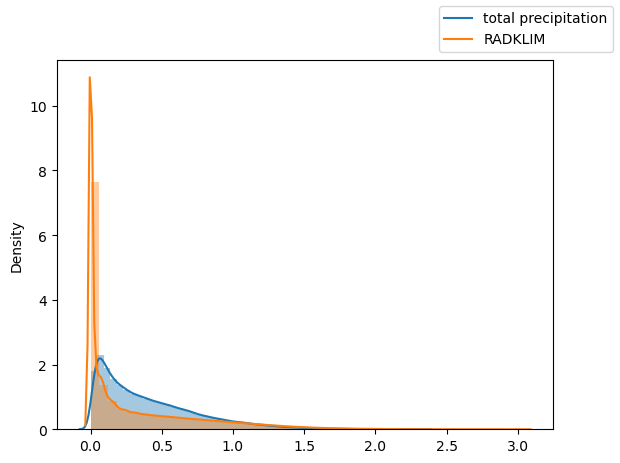

In [2]:
f2= "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240603_wgan_biascorrection_test/prcp_downs_wgan_2.nc"
df =  xr.open_dataset(f2, engine='netcdf4')


In [8]:
s1 = np.log(df["inputs"].values+1)
s2 =  np.log(df["hr"].values+1)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


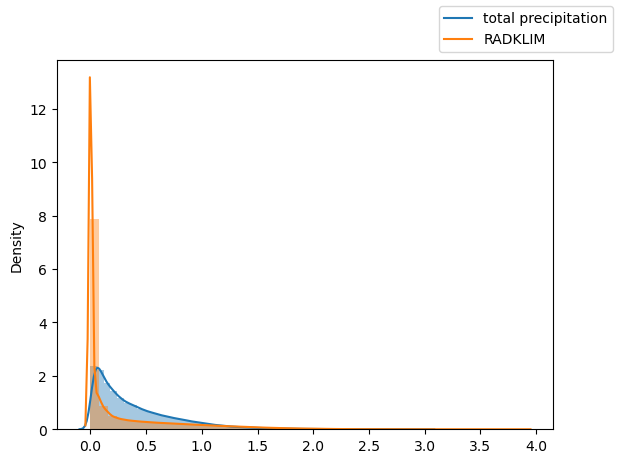

In [4]:
fig, ax = plt.subplots()
seaborn.distplot(a=s1)
seaborn.distplot(a=s2)
fig.legend(labels=['total precipitation','RADKLIM'])
plt.savefig("month2_dist.png")

In [7]:
fig_dir = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/figs"

In [13]:
def plot(imgs, with_orig=False, row_title=None):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
  
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(img, vmin=0, vmax=1)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.tight_layout()

In [9]:
# !pip install --user pysteps

In [29]:
# file_dir = "/p/scratch/deepacf/maelstrom/maelstrom_data/ap5/downscaling_precipitation/precip_dataset/test_small/"
# # file = os.path.join(file_dir,"preproc_ifs_radklim_2016-01.nc")
#file_out = os.path.join( "/p/scratch/deepacf/maelstrom/maelstrom_data/ap5/downscaling_precipitation/precip_dataset/train_small/preproc_ifs_radklim_2019-01.nc")
file_out = os.path.join("/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240603_wgan_biascorrection_train_test/prcp_downs_wgan_year_2018.nc")
#ds = xr.open_mfdataset('/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240603_wgan_biascorrection_test/*.nc',combine='nested')
df =  xr.open_dataset(file_out , engine='netcdf4')
lats =  np.array( df["lat"][:])
lons =  np.array( df["lon"][:])

# dt = df.isel(time=slice(1, 40))
# save_dir =  "/p/scratch/deepacf/maelstrom/maelstrom_data/ap5/downscaling_precipitation/precip_dataset/test_small/preproc_ifs_radklim_2020-03-small.nc"
# dt.to_netcdf(os.path.join(save_dir))

In [30]:
for i in range(len(df["hr"].values)):
    if np.max(df["hr"].values[i]) > 20:
        print(i)
        print(np.max(df["hr"].values[i]))
        print("_________")

2524
21.492
_________
2564
20.566086
_________
2565
35.600166
_________
2571
31.692749
_________
2593
21.541342
_________
2594
28.471472
_________
2595
31.339529
_________
2596
23.492283
_________
2628
28.158527
_________
2830
22.91774
_________


In [ ]:
#tp = [((df["cp_in"][i] +df["lsp_in"][i])*1000-(df["cp_in"][i-1] +df["lsp_in"][i-1])*1000).values for i in range(len(df.time))]

In [4]:
# len(tp[0])

In [30]:
# df["tp"]=(['time', 'lat', 'lon'], tp)

In [14]:
# np.min(df_new["yw_hourly_tar"]) #.plot(vmin=0, vmax=0.5)

In [ ]:
data = []
for i  in range(0,744):
    data.append(np.min(df["tp"][i].values))

In [ ]:
plt.plot(data[:18])

In [ ]:
# np.max(df["cp_in"])

In [7]:
# np.max(df["lsp_in"])

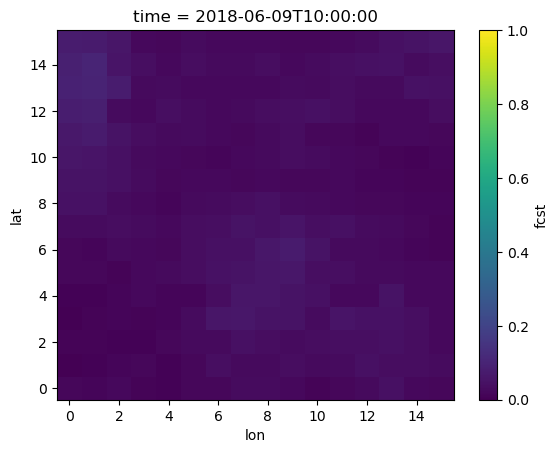

In [32]:
# for i in range(100,150):
i=2571
fig = plt.figure()
lons = df['lon'].values
lats =  df['lat'].values
pos = list(range(0,931,50))
pos_lons = list(range(0,1181,50))
#df["lsp_in"][i].plot()
#((df["cp_in"][i] +df["lsp_in"][i])*1000-(df["cp_in"][i-1] +df["lsp_in"][i-1])*1000).plot(vmin=0,vmax=2.5)
(df["fcst"][i]).plot(vmin=0,vmax=1)
# plt.ylabel("latitude")
# plt.xlabel("longitude")
# plt.yticks(ticks = pos,labels = lats[list(range(0,93,5))])
# plt.xticks(ticks = pos_lons,labels = lons[list(range(0,118,5))])
plt.savefig("bias_corred2565.png")


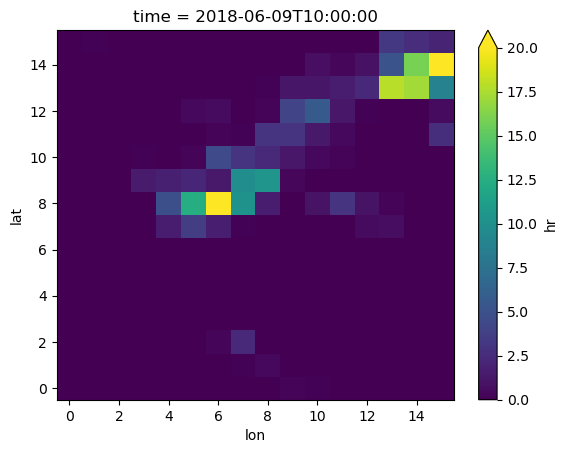

In [33]:
# for i in range(100,150):
fig = plt.figure()
lons = df['lon'].values
lats =  df['lat'].values
pos = list(range(0,931,50))
pos_lons = list(range(0,1181,50))
#df["lsp_in"][i].plot()
#((df["cp_in"][i] +df["lsp_in"][i])*1000-(df["cp_in"][i-1] +df["lsp_in"][i-1])*1000).plot(vmin=0,vmax=2.5)
(df["hr"][i]).plot(vmin=0,vmax=20)
# plt.ylabel("latitude")
# plt.xlabel("longitude")
# plt.yticks(ticks = pos,labels = lats[list(range(0,93,5))])
# plt.xticks(ticks = pos_lons,labels = lons[list(range(0,118,5))])
plt.savefig("hr100.png")

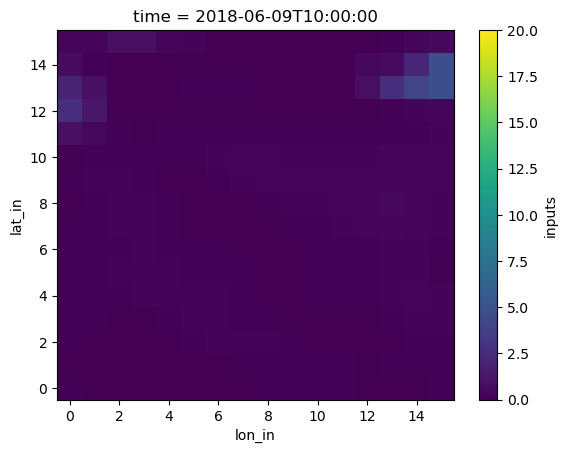

In [26]:
# for i in range(100,150):
fig = plt.figure()
lons = df['lon'].values
lats =  df['lat'].values
pos = list(range(0,931,50))
pos_lons = list(range(0,1181,50))
#df["lsp_in"][i].plot()
#((df["cp_in"][i] +df["lsp_in"][i])*1000-(df["cp_in"][i-1] +df["lsp_in"][i-1])*1000).plot(vmin=0,vmax=2.5)
(df["inputs"][i]).plot(vmin=0,vmax=20)
# plt.ylabel("latitude")
# plt.xlabel("longitude")
# plt.yticks(ticks = pos,labels = lats[list(range(0,93,5))])
# plt.xticks(ticks = pos_lons,labels = lons[list(range(0,118,5))])
plt.savefig("inputs100.png")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


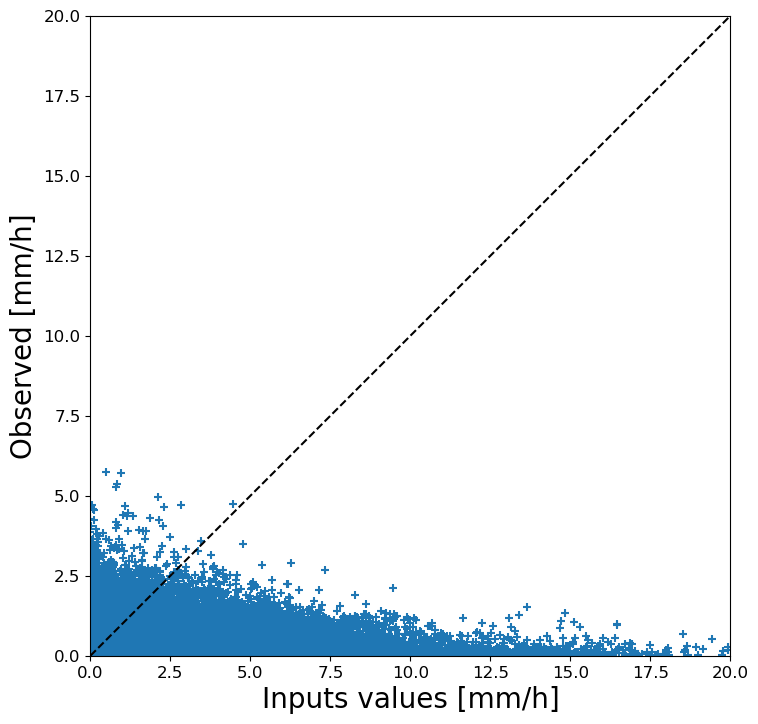

In [18]:
i=28
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#plt.scatter(df['refe'].values[:].flatten(),df['noiseP'].values[:].flatten(),marker='+')
plt.scatter(df['hr'].values.flatten(),df['fcst'].values.flatten(),marker='+')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
ax.plot((0, 20), (0, 20), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
ax.set_xlim([0,20])
ax.set_ylim([0,20])
ax.set_xlabel("Inputs values [mm/h]",fontsize=20)
ax.set_ylabel("Observed [mm/h]",fontsize=20)
figname = "diffusion"+'_scatters_harris'
#figpath = os.path.join(save_dir,figname)
#plt.savefig(figpath, bbox_inches="tight"
plt.show()

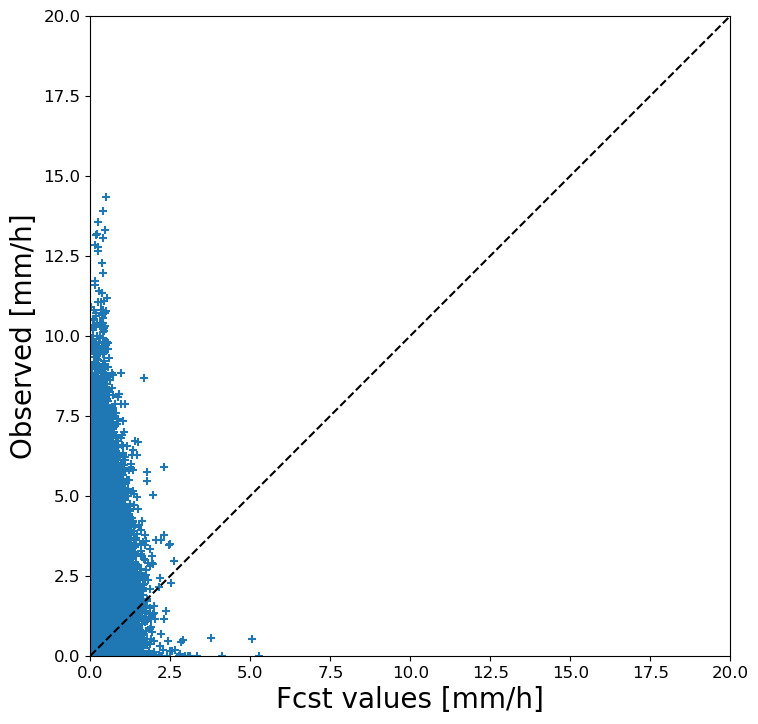

In [40]:

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#plt.scatter(df['refe'].values[:].flatten(),df['noiseP'].values[:].flatten(),marker='+')
plt.scatter(df['fcst'].values.flatten(),df['hr'].values.flatten(),marker='+')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
ax.plot((0, 20), (0, 20), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
ax.set_xlim([0,20])
ax.set_ylim([0,20])
ax.set_xlabel("Fcst values [mm/h]",fontsize=20)
ax.set_ylabel("Observed [mm/h]",fontsize=20)
figname = "diffusion"+'_scatters_harris'
#figpath = os.path.join(save_dir,figname)
#plt.savefig(figpath, bbox_inches="tight"
plt.show()

In [23]:
# for i in range(100,150):

fig = plt.figure()
lons = df['lon'].values
lats =  df['lat'].values
pos = list(range(0,931,50))
pos_lons = list(range(0,1181,50))
inputs = df.sel(lon = slice(8, 10)).sel(lat = slice(50, 52))
lats = inputs["lat"].values
lons = inputs["lon"].values
dx = lons[1] - lons[0]
lon_sl , lat_sl = slice(lons[0]- dx/2, lons[-1]+ dx/2), slice(lats[0]- dx, lats[-1]+dx)
#output = dt[self.var_out].sel({"lon_tar": lon_sl, "lat_tar":lat_sl})
output = df["yw_hourly_tar"].sel({"lon_tar": lon_sl, "lat_tar":lat_sl})
((inputs["cp_in"][i] + inputs["lsp_in"][i])*1000-(inputs["cp_in"][i-1] +inputs["lsp_in"][i-1])*1000).plot(vmin=0,vmax=2.5)
#output[i-1].plot(vmin=0,vmax=2.5)
# plt.ylabel("latitude")
# plt.xlabel("longitude")
# plt.yticks(ticks = pos,labels = lats[list(range(0,93,5))])
# plt.xticks(ticks = pos_lons,labels = lons[list(range(0,118,5))])
plt.savefig("input_{}.png".format(i))



IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


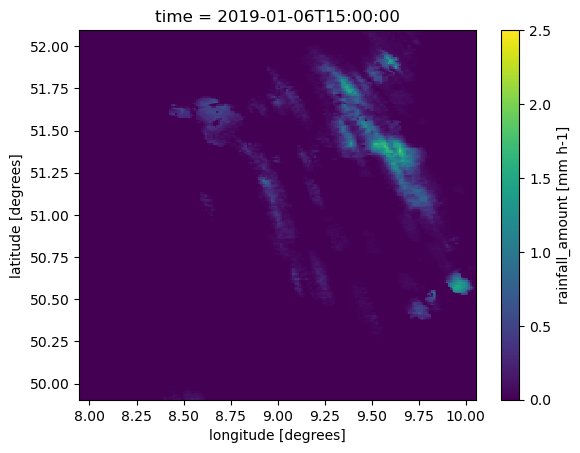

In [10]:
# for i in range(100,150):

fig = plt.figure()
lons = df['lon'].values
lats =  df['lat'].values
pos = list(range(0,931,50))
pos_lons = list(range(0,1181,50))
inputs = df.sel(lon = slice(8, 10)).sel(lat = slice(50, 52))

lats = inputs["lat"].values
lons = inputs["lon"].values
dx = lons[1] - lons[0]
lon_sl , lat_sl = slice(lons[0]- dx/2, lons[-1]+ dx/2), slice(lats[0]- dx, lats[-1]+dx)
#output = dt[self.var_out].sel({"lon_tar": lon_sl, "lat_tar":lat_sl})
output = df["yw_hourly_tar"].sel({"lon_tar": lon_sl, "lat_tar":lat_sl})

#((inputs["cp_in"][i] + inputs["lsp_in"][i])*1000-(inputs["cp_in"][i-1] +inputs["lsp_in"][i-1])*1000).plot(vmin=0,vmax=2.5)
output[i].plot(vmin=0,vmax=2.5)

# plt.ylabel("latitude")
# plt.xlabel("longitude")
# plt.yticks(ticks = pos,labels = lats[list(range(0,93,5))])
# plt.xticks(ticks = pos_lons,labels = lons[list(range(0,118,5))])
plt.savefig("target_{}.png".format(i))



In [ ]:

output[i].plot(vmin=0,vmax=2.5)

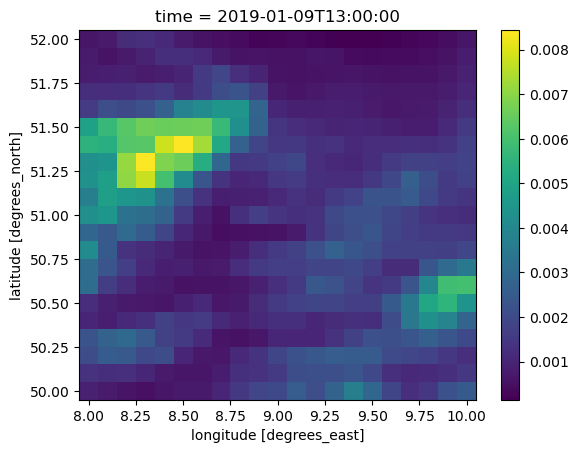

In [32]:
((inputs["cp_in"][i]+inputs["lsp_in"][i])).plot()

In [25]:
df["lsp_in"][i]

<xarray.DataArray 'lsp_in' (lat: 94, lon: 119)>
array([[ 2.946035e-03,  2.567554e-03,  2.257585e-03, ..., -1.742559e-18,
        -1.742559e-18, -1.742559e-18],
       [ 3.330503e-03,  2.981289e-03,  2.753136e-03, ..., -1.742559e-18,
        -1.742559e-18, -1.742559e-18],
       [ 3.261326e-03,  3.012552e-03,  2.865550e-03, ..., -1.742559e-18,
        -1.742559e-18, -1.742559e-18],
       ...,
       [ 6.512008e-04,  6.625087e-04,  6.704907e-04, ...,  8.248100e-04,
         9.930979e-04,  1.215930e-03],
       [ 6.272547e-04,  6.505357e-04,  6.445491e-04, ...,  7.982033e-04,
         9.724776e-04,  1.154069e-03],
       [ 5.826884e-04,  6.086300e-04,  6.046390e-04, ...,  8.028595e-04,
         9.518574e-04,  1.108172e-03]])
Coordinates:
    time     datetime64[ns] 2020-10-06T15:00:00
  * lon      (lon) float32 4.3 4.4 4.5 4.6 4.7 4.8 ... 15.7 15.8 15.9 16.0 16.1
  * lat      (lat) float32 46.5 46.6 46.7 46.8 46.9 ... 55.4 55.5 55.6 55.7 55.8
Attributes:
    standard_name:  lwe_thickness_of_stratiform_precipitation_amount
    long_name:      Large-scale precipitation
    units:          m

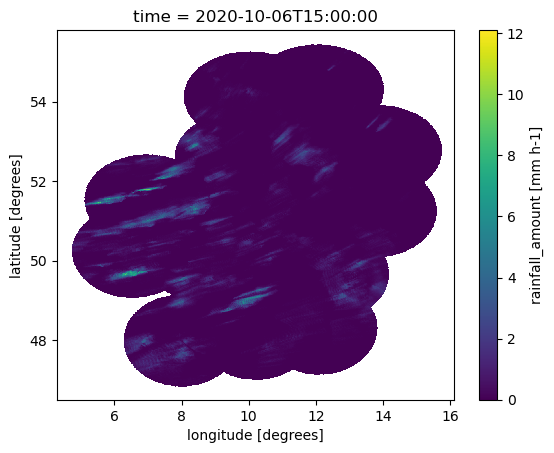

In [24]:
df["yw_hourly_tar"][i]。shape


In [31]:
len(lats)

94

In [48]:
np.max(df["yw_hourly_in"][114]) #.plot(vmin=0, vmax=0.5)

<xarray.DataArray 'yw_hourly_in' ()>
array(4.26048722)
Coordinates:
    time     datetime64[ns] 2020-10-05T23:00:00

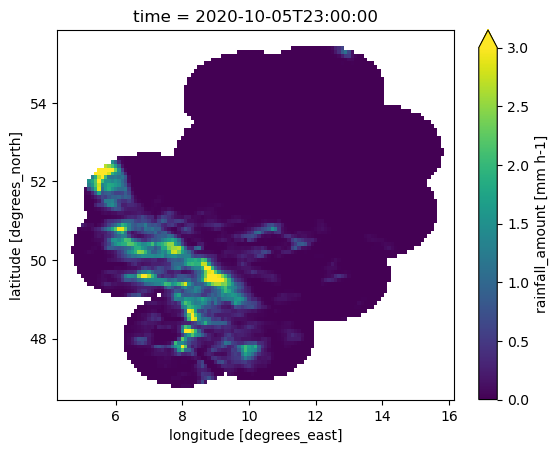

In [5]:
df["yw_hourly_in"][114].plot(vmin=0, vmax=3)
plt.savefig("yw_hourly_in.png")

In [11]:
df


<xarray.Dataset>
Dimensions:        (time: 744, lon: 119, lat: 94, lon_tar: 1181, lat_tar: 931)
Coordinates:
  * time           (time) datetime64[ns] 2020-03-01T05:00:00 ... 2020-04-01T0...
  * lon            (lon) float32 4.3 4.4 4.5 4.6 4.7 ... 15.8 15.9 16.0 16.1
  * lat            (lat) float32 46.5 46.6 46.7 46.8 ... 55.5 55.6 55.7 55.8
  * lon_tar        (lon_tar) float64 4.3 4.31 4.32 4.33 ... 16.08 16.09 16.1
  * lat_tar        (lat_tar) float64 46.5 46.51 46.52 46.53 ... 55.78 55.79 55.8
Data variables:
    cape_in        (time, lat, lon) float64 ...
    tclw_in        (time, lat, lon) float64 ...
    sp_in          (time, lat, lon) float64 ...
    tcwv_in        (time, lat, lon) float64 ...
    lsp_in         (time, lat, lon) float64 ...
    cp_in          (time, lat, lon) float64 ...
    tisr_in        (time, lat, lon) float64 ...
    u700_in        (time, lat, lon) float64 ...
    v700_in        (time, lat, lon) float64 ...
    yw_hourly_in   (time, lat, lon) float64 ...
    yw_hourly_tar  (time, lat_tar, lon_tar) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 13 15:58:20 2022: cdo merge /p/scratch/deepacf/deep...
    NCO:          netCDF Operators version 5.0.3 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.0.2 (https://mpimet.mpg.de...

In [12]:
import pickle 
import numpy as np
t_idx = [1,50,100,150,199]
b_idx= 1 #batch index
pk_file = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/HPC_scripts/example_5132_idx_2_t_{}.pkl".format(t_idx[2])
with open(pk_file, 'rb') as f:
    # dump information to that file
    data = pickle.load(f)
    
dt = np.array(data[b_idx,0,:,:])

In [13]:
dt.shape

(160, 160)

In [14]:
examples = []

for t in t_idx:
    pk_file = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/HPC_scripts/example_5132_idx_0_t_{}.pkl".format(t)
    with open(pk_file, 'rb') as f:
    # dump information to that file
        data = pickle.load(f)
    dt = np.array(data[b_idx,0,:,:])
    examples.append(dt)
examples = np.array(examples)

In [15]:
np.max(examples[2])

2.217885

In [16]:
# plot(examples)

In [ ]:
np.min(examples[0])

In [ ]:
np.max(examples[4])

In [ ]:
np.min(examples[4])

### Evaluate the model

In [64]:
#diffusion models
import xarray as xr

#f2 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_top_test_01/prcp_downs_diffusion_6.nc"
#exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_test for unet without top
threshold = [0.1,1,2,4,8] 
#f2 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_top_test/prcp_downs_unet_{}.nc".format(str(2))
f2= "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_biascorrection_test/prcp_downs_wgan_10.nc"
f2="/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_biascorrection_test/prcp_downs_unet_10.nc"
#f2 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240430_biascorrection_test/prcp_downs_diffusion2_8.nc"
model = "unet"
df =  xr.open_dataset(f2, engine='netcdf4')
times = df["time"].values
lats =  np.array( df["lats"][0])
lons =  np.array( df["lons"][0])
pos = list(range(0,16,2))
pos_hr=list(range(0,160,20))

In [21]:
df["lats"][0]

<xarray.DataArray 'lats' (lat: 160)>
array([52.21, 52.22, 52.23, 52.24, 52.25, 52.26, 52.27, 52.28, 52.29, 52.3 ,
       52.31, 52.32, 52.33, 52.34, 52.35, 52.36, 52.37, 52.38, 52.39, 52.4 ,
       52.41, 52.42, 52.43, 52.44, 52.45, 52.46, 52.47, 52.48, 52.49, 52.5 ,
       52.51, 52.52, 52.53, 52.54, 52.55, 52.56, 52.57, 52.58, 52.59, 52.6 ,
       52.61, 52.62, 52.63, 52.64, 52.65, 52.66, 52.67, 52.68, 52.69, 52.7 ,
       52.71, 52.72, 52.73, 52.74, 52.75, 52.76, 52.77, 52.78, 52.79, 52.8 ,
       52.81, 52.82, 52.83, 52.84, 52.85, 52.86, 52.87, 52.88, 52.89, 52.9 ,
       52.91, 52.92, 52.93, 52.94, 52.95, 52.96, 52.97, 52.98, 52.99, 53.  ,
       53.01, 53.02, 53.03, 53.04, 53.05, 53.06, 53.07, 53.08, 53.09, 53.1 ,
       53.11, 53.12, 53.13, 53.14, 53.15, 53.16, 53.17, 53.18, 53.19, 53.2 ,
       53.21, 53.22, 53.23, 53.24, 53.25, 53.26, 53.27, 53.28, 53.29, 53.3 ,
       53.31, 53.32, 53.33, 53.34, 53.35, 53.36, 53.37, 53.38, 53.39, 53.4 ,
       53.41, 53.42, 53.43, 53.44, 53.45, 53.46, 53.47, 53.48, 53.49, 53.5 ,
       53.51, 53.52, 53.53, 53.54, 53.55, 53.56, 53.57, 53.58, 53.59, 53.6 ,
       53.61, 53.62, 53.63, 53.64, 53.65, 53.66, 53.67, 53.68, 53.69, 53.7 ,
       53.71, 53.72, 53.73, 53.74, 53.75, 53.76, 53.77, 53.78, 53.79, 53.8 ],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2020-08-02T08:00:00
Dimensions without coordinates: lat

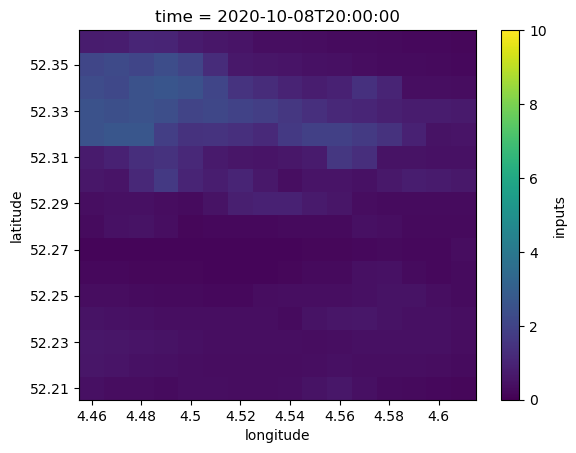

In [66]:
i=300
df["inputs"][i].plot(vmin=0, vmax=10)
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos,labels = lats[list(range(0,16,2))])
plt.xticks(ticks = pos,labels = lons[list(range(0,16,2))])
plt.savefig( model + "_bias_correction_"+str(i) + "inputs.png")

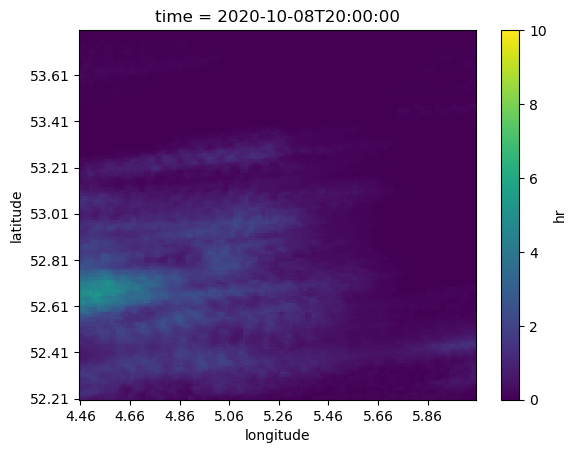

In [67]:
df["hr"][i].plot(vmin=0, vmax=10)
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
plt.savefig( model + "_bias_correction_"+str(i) + "hr.png")

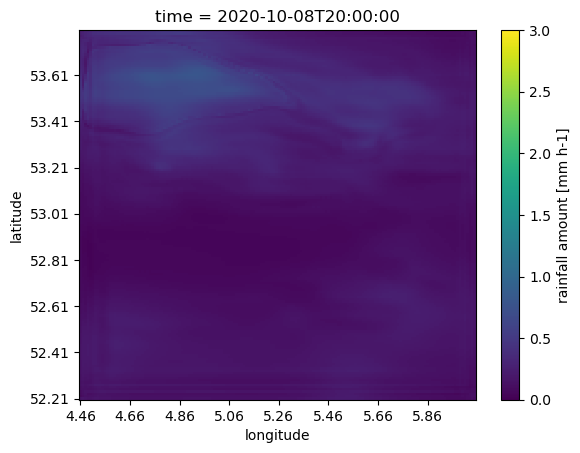

In [65]:
df['fcst'][i].plot(vmin=0, vmax=3,cbar_kwargs={"label":"rainfall amount [mm h-1]"})
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
plt.savefig( model + "_bias_correction_"+str(i) + "fcst.png")

In [2]:
ffs_mean_all = []
scales = list(range(0,60,10))
for i in range(2,12):
    f2= "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_top_test_02/prcp_downs_diffusion_{}.nc".format(str(i))
    #f2 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_top_test/prcp_downs_unet_{}.nc".format(str(i))
    df =  xr.open_dataset(f2, engine='netcdf4')
    times = df["time"].values
    samples = list(range(df['fcst'].values.shape[0]))
    spl = random.sample(samples, 200)
   
    scales = list(range(0,160,10))
    def ffs_scores(t):
        ffs_score = [[fss(df['fcst'].values[s], df['hr'].values[s], t, scale) for s in spl ] for scale in scales]
        ffs_score_mean = [ np.mean([i for i in item  if i > 0 ]) for item in ffs_score]
        return ffs_score_mean
    ffs_score_mean =  ffs_scores(8)
    ffs_mean_all.append(ffs_score_mean)

ffs_std_all = np.std(np.array(ffs_mean_all), axis=0)
ffs_mean_all_mean = np.mean(np.array(ffs_mean_all), axis=0)


In [5]:
ffs_mean_all_mean

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan])

In [22]:
df["hr"].values.shape

(2667, 160, 160)

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar(scales,ffs_mean_all_mean,ffs_std_all,label=str(0.1))
ax.set_xlim([0,60])
ax.set_ylim([0,1])

std for 0.1 [0.05036508 0.04058571 0.04044381 0.04198759 0.04360213 0.0428496
 0.04370551 0.04407426]
std for 1 [0.0398621  0.05123332 0.04730136 0.04457331 0.04227755 0.04131238
 0.04174012 0.04212269]
std for 2 [0.06069729 0.07750459 0.08681887 0.08893154 0.08782746 0.08976705
 0.09242398 0.09270205]
std for 4 [0.0595462  0.07650414 0.09293811 0.09991769 0.10455712 0.10761107
 0.10835739 0.11003764]
std for 8 [0.07850934 0.1507592  0.1649395  0.15205944 0.14520713 0.14052129
 0.1370651  0.13337462]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


std for 16 [0.0719416  0.16999196 0.21827611 0.23816841 0.24460951 0.24716626
 0.24768251 0.16484135]


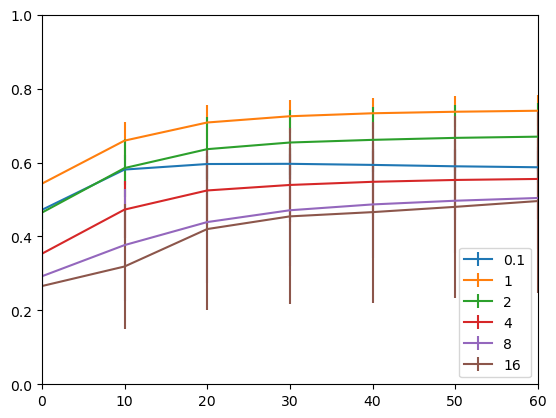

In [3]:
threshold = [0.1,1,2,4,8,16] 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.boxplot(ffs_std_all ,meanline =True, showfliers=False)
for t in threshold:
    ffs_mean_all = []
    for i in range(2,12):
        f2 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_test/prcp_downs_diffusion_{}.nc".format(str(i))
        df =  xr.open_dataset(f2, engine='netcdf4')
        #if diffusion
        fcst_diff = df['fcst'].values
        df['fcst'].values = slope * fcst_diff  + intercept
        times = df["time"].values
        samples = list(range(df['fcst'].values.shape[0]))
        spl = random.sample(samples, 200)
        scales = list(range(0,80,10))
        def ffs_scores(t):
            ffs_score = [[fss(df['fcst'].values[s], df['hr'].values[s], t, scale) for s in spl ] for scale in scales]
            ffs_score_mean = [ np.mean([i for i in item  if i > 0 ]) for item in ffs_score]
            return ffs_score_mean
        ffs_score_mean =  ffs_scores(t)
        ffs_mean_all.append(ffs_score_mean)
    ffs_std_all = np.nanstd(np.array(ffs_mean_all), axis=0)
    ffs_mean_all_mean = np.nanmean(np.array(ffs_mean_all), axis=0)
    print("std for {}".format(t),ffs_std_all)
    ax.errorbar(scales, ffs_mean_all_mean,ffs_std_all,label=str(t))
ax.set_xlim([0,60])
ax.set_ylim([0,1])
plt.legend(loc= 'lower right')
# plt.show()
plt.savefig("ffs_diffusion.png")


In [50]:
samples_all = []
for i in range(2,12):
    f2 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_top_test/prcp_downs_unet_{}.nc".format(str(i))
    df =  xr.open_dataset(f2, engine='netcdf4')
    times = df["time"].values
    samples = list(range(df['hr'].values.shape[0]))
    spl = random.sample(samples, 400)
    samples_year = [df["hr"].values[s] for s in spl ]
    samples_all.append(samples_year)


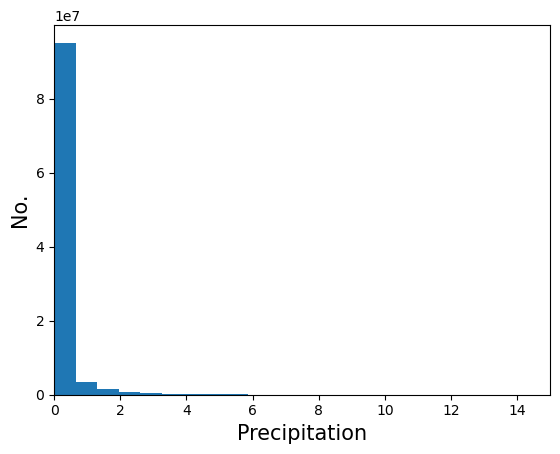

In [53]:
    
# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Draw the plot
ax.hist(np.array(samples_all).flatten(),bins=100)

# Title and labels
#ax.set_title('Histogram with Binwidth = %d' % 1, size = 30)
ax.set_xlabel('Precipitation', size = 15)
ax.set_ylabel('No.', size= 15)
ax.set_xlim([0,15])
plt.savefig("hist_hr.png")

In [8]:
rf_all = []
for j in range(10):   
    ffs_all = []
    ffs_wgan_all = []
    for i in range(2,12):
        f2 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_top_test/prcp_downs_unet_{}.nc".format(str(i))
        df =  xr.open_dataset(f2, engine='netcdf4')
        samples = list(range(df['fcst'].values.shape[0]))
        
        f3 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_test/prcp_downs_diffusion_{}.nc".format(str(i)) 
        #f3 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test_01/prcp_downs_wgan_{}.nc".format(str(i))
        df3 =  xr.open_dataset(f3, engine='netcdf4')
        fcst_diff = df3['fcst'].values
        df3['fcst'].values = slope * fcst_diff  + intercept

        random.seed(j) 
        spl = random.sample(samples, 100)
        def ffs_scores(t, df):
            ffs_score = [fss(df['fcst'].values[s], df['hr'].values[s], t, 20) for s in spl] 
            ffs_score_all = [i for i in ffs_score if i > 0 ]
            return ffs_score_all

        ffs_score_all =  ffs_scores(8,df)
        ffs_score_all_wgan =  ffs_scores(8,df3)
        ffs_all.extend(ffs_score_all)
        ffs_wgan_all.extend(ffs_score_all_wgan )

    ffs_mean_wgan = np.nanmean(np.array( ffs_wgan_all))
    ffs_mean_unet = np.nanmean(np.array( ffs_all))
    rf = [(ffs_mean_wgan-ffs_mean_unet)/ffs_mean_unet]
    rf_all.extend(rf)

In [6]:
rf_wgan_skill =  rf_all

In [9]:
rf_diffusion_skill = rf_all

In [11]:
rf_diffusion_skill 

[1.3381077924014888,
 0.9204402926563374,
 1.150988880785899,
 0.525781873853474,
 0.8921998422924075,
 0.08630146826658251,
 0.651526825104037,
 0.5433197095085486,
 1.6225553460733348,
 0.2526732949792438]

In [7]:
rf_wgan_skill

[1.6357779234914025,
 1.3207779108781013,
 1.208331319302001,
 0.6187631068936164,
 1.2174780459032506,
 0.17212208659455688,
 0.7621461914563501,
 0.7232952405774461,
 1.695064374334389,
 0.42867080813083847]

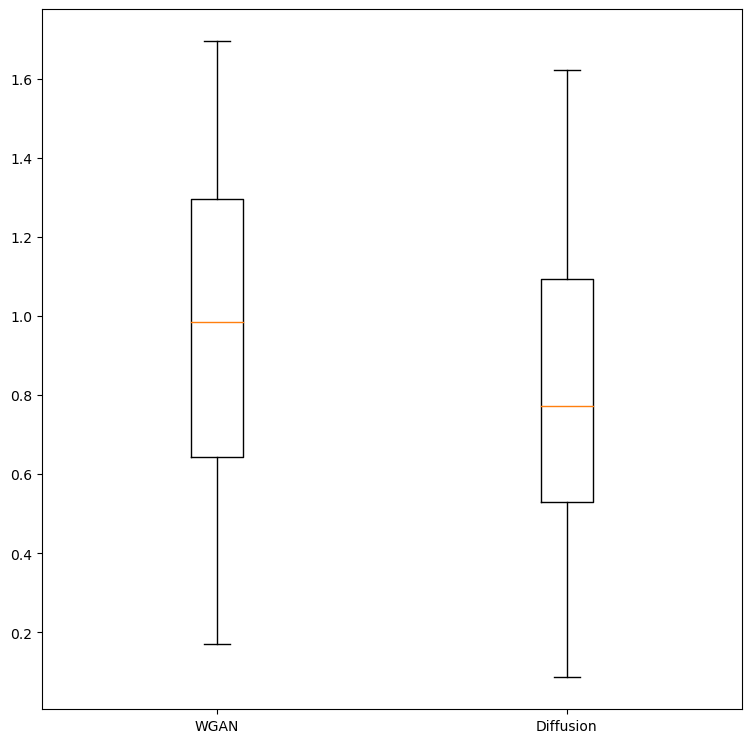

In [13]:
data = [rf_wgan_skill,rf_diffusion_skill]
 
fig = plt.figure(figsize =(7, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
plt.xticks(ticks = [1,2],labels = ["WGAN","Diffusion"])
# show plot
plt.savefig("t8_ffs_skill.png")

In [11]:
import pickle as pkl
with open('wgan_skill.pkl', 'wb') as f:
    pkl.dump(rf_wgan_skill , f)

In [17]:
#calculate the fracktion still scores for wgan and unet with t=4， s=20
i=2
f_wgan = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test_01/prcp_downs_wgan_{}.nc".format(str(i))
df =  xr.open_dataset(f_wgan, engine='netcdf4')
for s in range(1,50):
    score = fss(df['fcst'].values[s], df['hr'].values[s], 4, 20)
    print("score",score)

score 0.9721973942811074
score nan
score 0.0
score nan
score 0.0
score 0.0
score nan
score nan
score nan
score nan
score nan
score nan
score 0.0
score nan
score 0.0
score nan
score 0.0
score 0.0
score nan
score 0.0
score 0.5054171694920537
score nan
score 0.20063827441950788
score nan
score nan
score nan
score nan
score 0.9307899208915524
score 0.7925968307725986
score nan
score 0.9015802137921601
score 0.7614378681372171
score 0.0
score nan
score nan
score nan
score nan
score nan
score nan
score 0.6843766037036447
score nan
score 0.29891556588994417
score nan
score 0.0
score nan
score nan
score 0.0
score nan
score nan


In [19]:
#ffs_score = [[[fss(df['fcst'].values[s], df['hr'].values[s], t, scale)  for s in spl] for t in threshold] for scale in scales]
#fss(df['fcst'].values[i], df['hr'].values[i], threshold, scales)
#ffs_score_std = [ np.std([i for i in item  if i > 0 ]) for item in ffs_score]

In [12]:
#[fss(df['fcst'].values[s], df['hr'].values[s], 0.1, 1)  for s in range(samples)]

In [5]:
# for i in range(4000):
#     if np.max(df['hr'][i].values) < 30 and np.max(df['hr'][i].values) > 25: 
#         print(i)
#         print(np.max(df['hr'][i].values))
#         print("_______")

In [6]:
i = 127

In [8]:
fcst = df['fcst'][i].values

In [9]:
hr = df['hr'][i].values

In [2]:
# lons = df['lons'][i].values
# lats =  df['lats'][i].values
# pos = list(range(0,16,2))

In [11]:
len(lons)

160

## FFS comparsion

In [3]:
for i in range(2,12):
    f_unet = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_top_test/prcp_downs_unet_{}.nc".format(str(i))
    df =  xr.open_dataset(f2, engine='netcdf4')
    times = df["time"].values
    samples = list(range(df['hr'].values.shape[0]))
    spl = random.sample(samples, 400)
    samples_year = [df["hr"].values[s] for s in spl ]
    samples_all.append(samples_year)


NameError: name 'f2' is not defined

In [12]:
lons[list(range(0,160,20))]

array([14.06, 14.26, 14.46, 14.66, 14.86, 15.06, 15.26, 15.46],
      dtype=float32)

In [13]:
# for i in range(180):
#     print(i)
#     print(np.max(df['inputs'][i].values))

In [1]:

#for i in range(30,35):
fig, ax = plt.subplots()
df['inputs'][i].plot(vmin=0, vmax=20,cbar_kwargs={"label":"rainfall amount [mm h-1]"})
# plt.title("Low resolution input ")
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos,labels = lats[list(range(0,160,20))])
plt.xticks(ticks = pos,labels = lons[list(range(0,160,20))])
ax.legend(labels="rainfall amount [mm h-1]")
plt.savefig( str(i) + "inputs.png")

NameError: name 'plt' is not defined

In [15]:
np.max(df['inputs'][i].values)

19.435963

In [16]:
np.max(df['hr'][i].values)

29.2491

In [17]:
np.max(df['fcst'][i].values)

15.222258

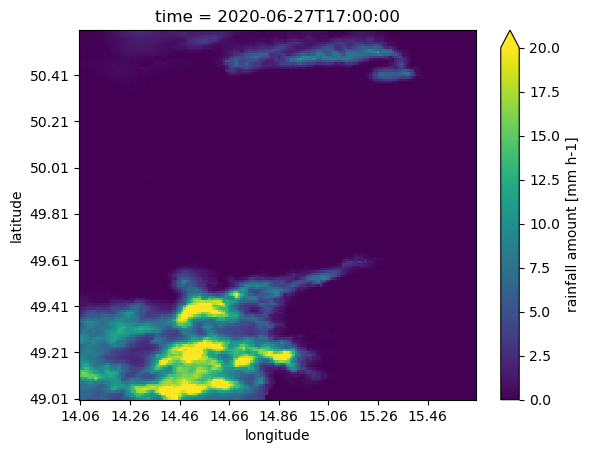

In [19]:
df['hr'][i].plot(vmin=0, vmax=20,cbar_kwargs={"label":"rainfall amount [mm h-1]"})
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
plt.savefig( str(i) + "hr.png")

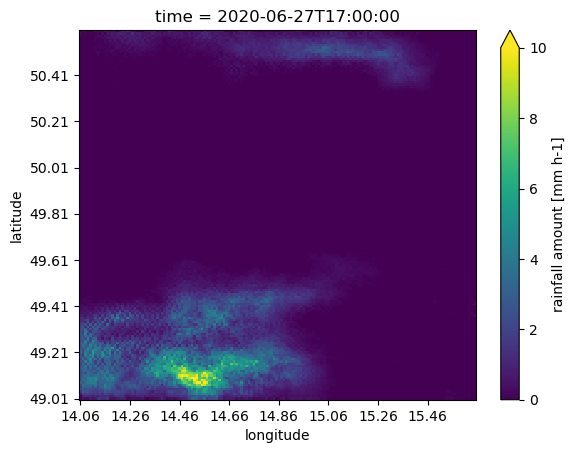

In [20]:
df['fcst'][i].plot(vmin=0, vmax=10,cbar_kwargs={"label":"rainfall amount [mm h-1]"})
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
plt.savefig(str(i) + "diffusion.png")

In [32]:
df['hr'].values.shape

(5143, 160, 160)

In [95]:
np.max(np.concatenate(df['fcst'].values))

52.177227

In [96]:
np.max(np.concatenate(df['fcst'].values))

52.177227

In [43]:
np.max(np.concatenate(np.concatenate(df['hr'].values)))

30.836567

(array([16403.,  1030.,   638.,   442.,   392.,   339.,   335.,   298.,
          280.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <BarContainer object of 9 artists>)

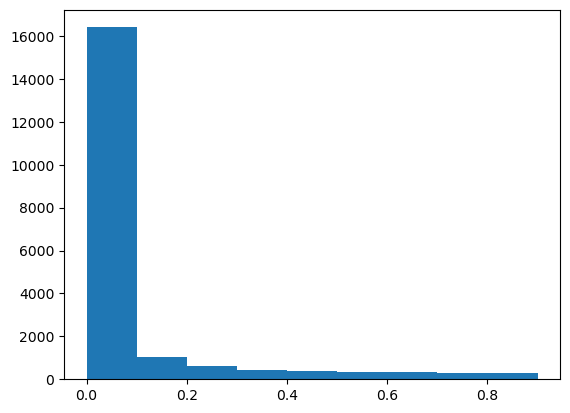

In [24]:
plt.hist(np.concatenate(df['hr'][i].values), bins=np.arange(0,1,0.1))

(array([15408.,  1281.,  1078.,   904.,   822.,   713.,   661.,   567.,
          434.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <BarContainer object of 9 artists>)

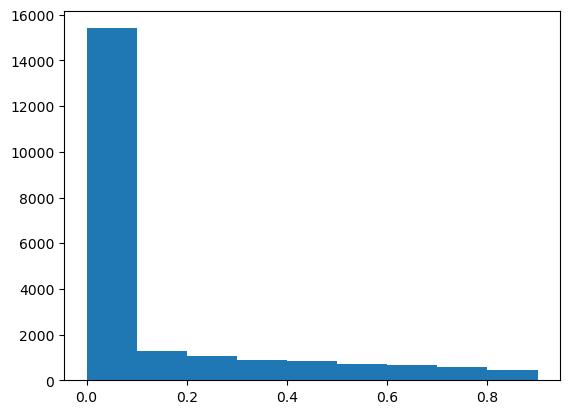

In [25]:
plt.hist(np.concatenate(df['fcst'][i].values), bins=np.arange(0,1,0.1))

In [69]:
np.max(df['hr'])

<xarray.DataArray 'hr' ()>
array(76.88290405)

In [31]:
np.max(df['inputs'])

<xarray.DataArray 'inputs' ()>
array(13.39460182)

In [32]:
np.min(df['inputs'])

<xarray.DataArray 'inputs' ()>
array(0.)

In [21]:
data = [df['fcst_first'][i].values]

In [33]:
np.max(df['fcast_last'])

<xarray.DataArray 'fcast_last' ()>
array(0.91483986)

In [23]:
np.min(df['fcast_last'])

<xarray.DataArray 'fcast_last' ()>
array(-0.39377263)

In [24]:
np.min(df['fcst_first'])

<xarray.DataArray 'fcst_first' ()>
array(-5.45247698)

In [25]:
np.max(df['fcst_first'][i])

<xarray.DataArray 'fcst_first' ()>
array(4.11381626)
Coordinates:
    time     datetime64[ns] 2020-03-02T01:00:00

In [26]:
df['fcst_first'][i].shape

(160, 160)

In [34]:
data = [df['fcst_first'][i].values]
fcst_str = ['fcst_50','fcst_100','fcst_150','fcast_last']
for fcst in fcst_str:
    dff = df[fcst][i].values
    data.append(dff)

In [35]:
plot(np.array(data))

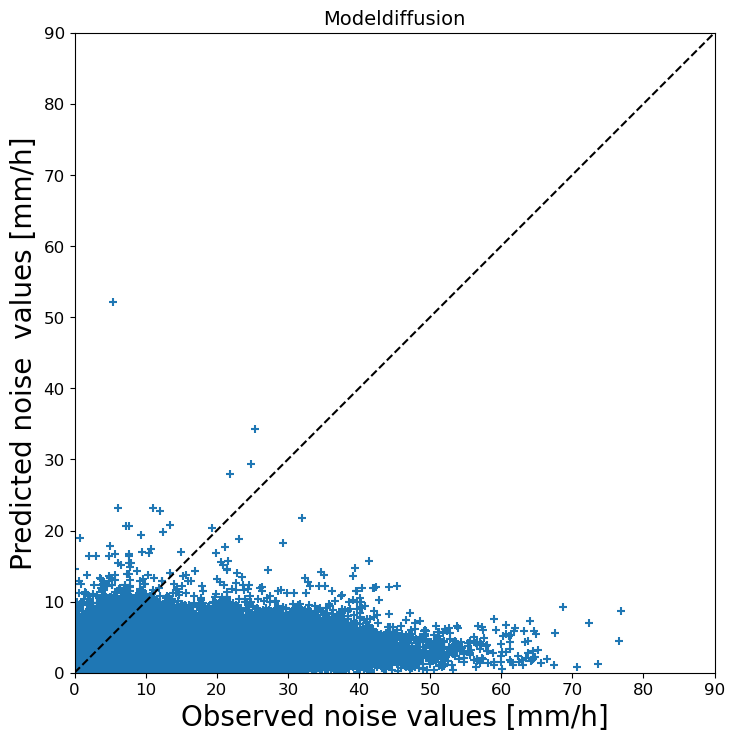

In [70]:
plot_scatter(df)

In [ ]:
np.max(df['fcst'])

# Plot the results

In [51]:
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_axes([0.1,0.1,0.8,0.8])
# #plt.scatter(df['refe'].values[:].flatten(),df['noiseP'].values[:].flatten(),marker='+')
# plt.scatter(df['refe'].values[:].flatten(),df['noiseP'].values[:].flatten(),marker='+')
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# # plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# # legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
# ax.plot((0, 5), (0, 5), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
# ax.set_xlim([0,5])
# ax.set_ylim([0,5])
# ax.set_xlabel("Observed noise values [mm/h]",fontsize=20)
# ax.set_ylabel("Predicted noise  values [mm/h]",fontsize=20)
# figname = "diffusion"+'_scatters'
# #figpath = os.path.join(save_dir,figname)
# #plt.savefig(figpath, bbox_inches="tight"
# plt.show()

In [4]:
#UNETprcp_downs_unet_3.nc_
f2_unet = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_top_test_01/prcp_downs_diffusion_8.nc"
df_unet =  xr.open_dataset(f2_unet, engine='netcdf4')

#when october, the sample i = 29, 81, 207, 359
#When June, the sample i = 28, 45, 127, 204, 331, 349
# When April, thes ample i = 329,426

In [5]:
fcst_unet = df_unet['fcst'].values
fcst_unet = slope * fcst_unet + intercept
df_unet['fcst'].values = fcst_unet 

In [28]:
rmse_unet = [np.sum(np.square(df_unet['fcst'].values[s] - df_unet['hr'].values[s]).flatten())/(160*160) for s in range(df_unet['fcst'].values.shape[0])]

In [ ]:
fig, ax = plt.subplots()
seaborn.histplot(np.log(df_unet['fcst'].values[0] + 0.5)-np.log(0.5))
seaborn.histplot(np.log(df_unet['hr'].values[0]+ 0.5)-np.log(0.5))
fig.legend(labels=['Diffusion','HR'])
plt.savefig("diffusion.png")

In [31]:
np.mean(np.array(rmse_unet))

0.07962692335406298

0.06741035929684022

In [14]:
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_axes([0.1,0.1,0.8,0.8])
# #plt.scatter(df['refe'].values[:].flatten(),df['noiseP'].values[:].flatten(),marker='+')
# plt.scatter(df_unet['hr'].values.flatten(),df_unet['fcst'].values.flatten(),marker='+')
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# # plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# # legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
# ax.plot((0, 40), (0, 40), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
# ax.set_xlim([0,40])
# ax.set_ylim([0,40])
# ax.set_xlabel("Observed [mm/h]",fontsize=20)
# ax.set_ylabel("Predicted [mm/h]",fontsize=20)
# figname = "M9_scatter_diffusion.png"
# #figpath = os.path.join(save_dir,figname)
# #plt.savefig(figname , bbox_inches="tight")
# plt.show()

In [29]:
#wgan prcp_downs_unet_3.nc
f2_wgan = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_test/prcp_downs_unet_2.nc"
df_wgan =  xr.open_dataset(f2_wgan, engine='netcdf4')
fcst_wgan = df_wgan['fcst'].values


In [30]:
rmse_wgan = [np.sum(np.square(df_wgan['fcst'].values[s] - df_wgan['hr'].values[s]).flatten())/(160*160) for s in range(df_wgan['fcst'].values.shape[0])]

In [32]:
np.mean(np.array(rmse_wgan))

0.03503997513587481

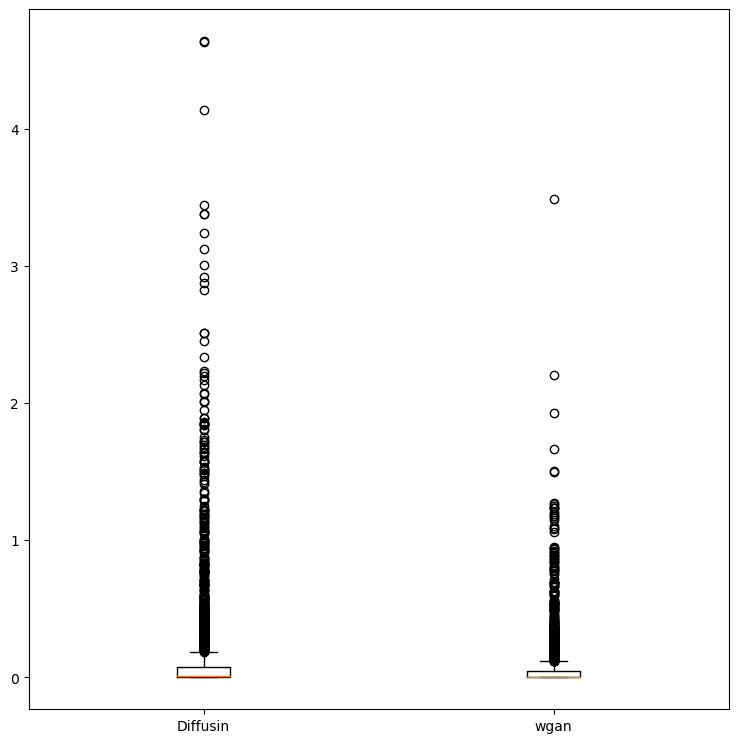

In [20]:
data = [rmse_unet,rmse_wgan]
 
fig = plt.figure(figsize =(7, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
plt.xticks(ticks = [1,2],labels = ["Diffusin","wgan"])
# show plot
plt.savefig("t4_ffs_skill.png")

In [84]:
# for i in range(450,500):
#     fig = plt.figure(figsize=(4,4))
#     df_wgan['hr'][i].plot(vmin=0, vmax=20,cbar_kwargs={"label":"rainfall amount [mm h-1] , " + str(i)})
#     plt.ylabel("latitude")
#     plt.xlabel("longitude")
#     plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
#     plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
#     #plt.savefig( str(i) + "wgan_top.png")

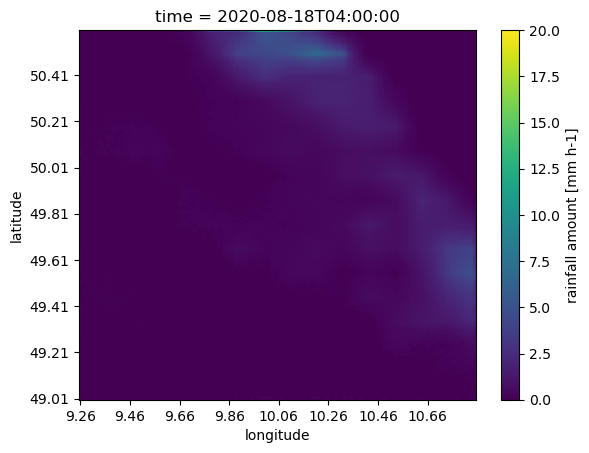

In [4]:
i=3720
lons = df_unet['lons'][i].values
lats =  df_unet['lats'][i].values
fig = plt.figure()
df_unet['fcst'][i].plot(vmin=0, vmax=20,cbar_kwargs={"label":"rainfall amount [mm h-1]" })
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
plt.savefig(str(i) + "diffusion.png")

In [33]:
df_unet['lon'].values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159])

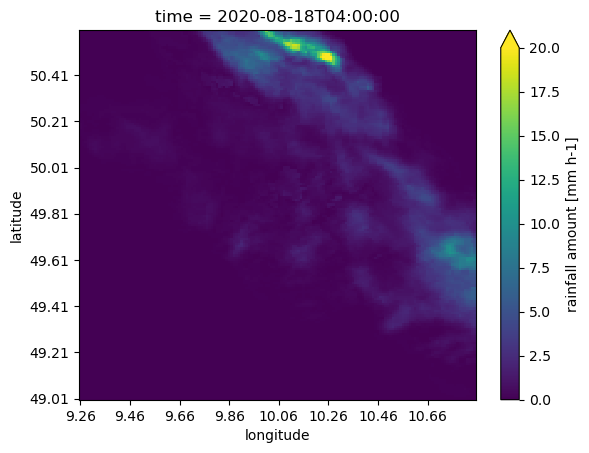

In [5]:
df_unet['hr'][i].plot(vmin=0, vmax=20,cbar_kwargs={"label":"rainfall amount [mm h-1]" })
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
plt.savefig( str(i) + "unet.png")

Text(0, 0.5, 'latitude')

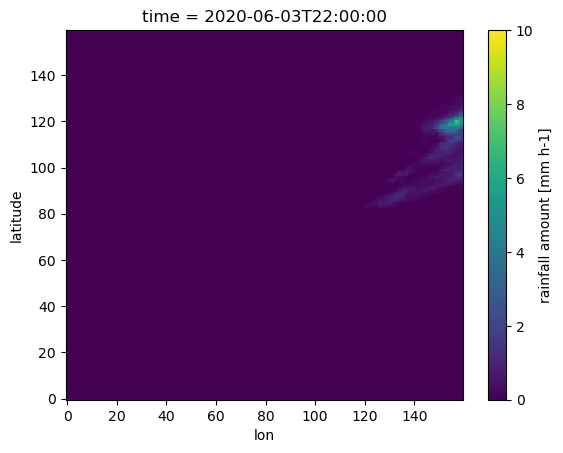

In [33]:
df_unet['hr'][i].plot(vmin=0, vmax=10,cbar_kwargs={"label":"rainfall amount [mm h-1]" })
plt.ylabel("latitude")
# plt.xlabel("longitude")
# plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
# plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
#plt.savefig( str(i) + "hr.png")

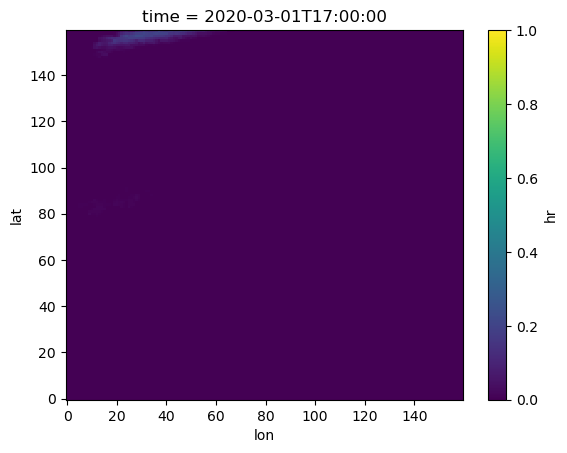

In [6]:
for i in range(1):
    df_unet["hr"][i].plot(vmin=0, vmax=1)
    plt.show()

In [ ]:
df_unet["inputs"][i].plot(vmin=0, vmax=1)

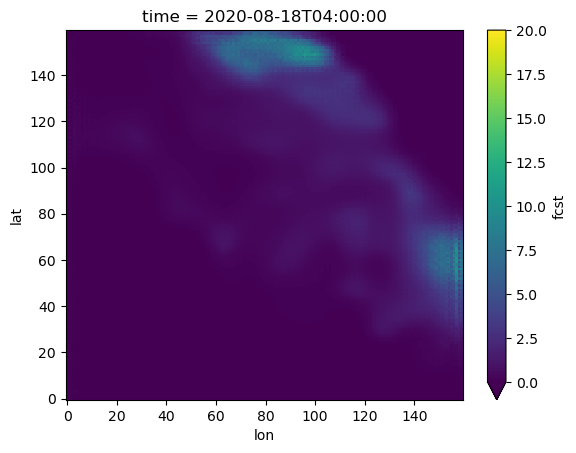

In [98]:
df_wgan['fcst'][i].plot(vmin=0, vmax=20)

In [65]:
f2_wgan_top = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test_02/prcp_downs_wgan_8.nc"
df_wgan_top =  xr.open_dataset(f2_wgan_top, engine='netcdf4')
fcst_wgan_top = df_wgan_top['fcst'][i].values

In [64]:
f2_wgan_top1 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test_01/prcp_downs_wgan_8.nc"
df_wgan_top1 =  xr.open_dataset(f2_wgan_top1, engine='netcdf4')
fcst_wgan_top1 = df_wgan_top1['fcst'][i].values

In [43]:
np.max(fcst_wgan_top)

12.451781

In [47]:
np.max(fcst_wgan_top)

12.629408

In [55]:
fcst_wgan_top - fcst_wgan_top1 


array([[-4.2641163e-04,  4.2021275e-06, -1.2458861e-03, ...,
        -7.7539682e-04, -5.8174133e-04, -7.6878071e-04],
       [ 1.0057092e-03,  1.2032390e-03, -8.6247921e-04, ...,
        -9.8764896e-05, -9.2172623e-04, -8.3529949e-04],
       [-9.7489357e-04,  1.9347668e-04, -3.0981004e-03, ...,
        -9.5957518e-04, -9.3543530e-04, -7.5501204e-04],
       ...,
       [-3.8284063e-04, -1.0589957e-03,  6.7563653e-03, ...,
         6.3478947e-05, -9.8079443e-05,  2.5892258e-04],
       [ 1.4675260e-03,  2.6866794e-04, -8.3148479e-04, ...,
         2.5510788e-04,  2.9090047e-04,  3.2076240e-04],
       [ 2.2028089e-03,  5.2514672e-04,  3.0104518e-03, ...,
         1.2192130e-04,  5.2765012e-04, -6.4074993e-05]], dtype=float32)

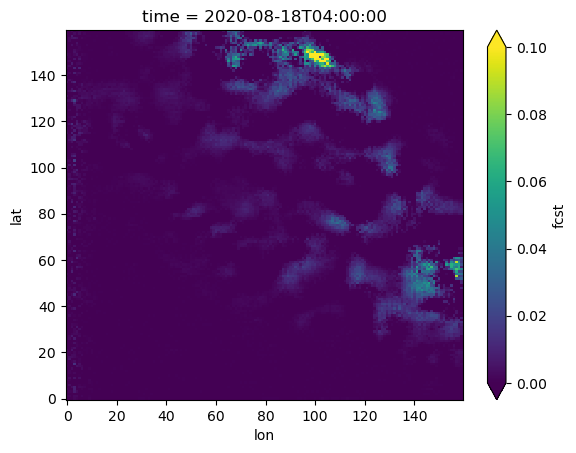

In [69]:
(df_wgan_top['fcst'][i]-df_wgan_top1['fcst'][i].values).plot(vmin=0, vmax=0.1)

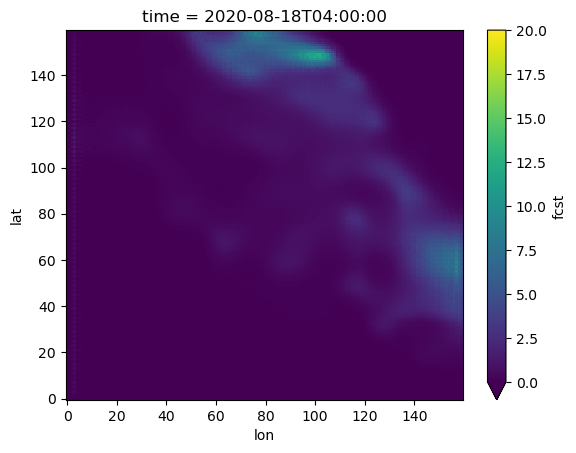

In [70]:
f2_wgan_top2= "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test/prcp_downs_wgan_8.nc"
df_wgan_top2 =  xr.open_dataset(f2_wgan_top2, engine='netcdf4')
fcst_wgan_top2 = df_wgan_top2['fcst'][i].values
df_wgan_top2['fcst'][i].plot(vmin=0, vmax=20)

In [71]:
np.max(fcst_wgan_top2)

12.451781

In [18]:
df_unet


<xarray.Dataset>
Dimensions:     (time: 272, lat_in: 16, lon_in: 16, lat: 160, lon: 160,
                 pitch_idx: 272)
Coordinates:
  * time        (time) datetime64[ns] 2020-03-01T17:00:00 ... 2020-03-01T09:0...
  * pitch_idx   (pitch_idx) int32 87 245 162 55 114 263 ... 2 247 251 134 155 31
Dimensions without coordinates: lat_in, lon_in, lat, lon
Data variables:
    inputs      (time, lat_in, lon_in) float32 ...
    fcst        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fcst_first  (time, lat, lon) float32 ...
    fcast_last  (time, lat, lon) float32 ...
    fcst_50     (time, lat, lon) float32 ...
    fcst_100    (time, lat, lon) float32 ...
    fcst_150    (time, lat, lon) float32 ...
    refe        (time, lat, lon) float32 ...
    noiseP      (time, lat, lon) float32 ...
    hr          (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lats        (time, lat) float32 ...
    lons        (time, lon) float32 ...
Attributes:
    description:  Precipitation downscaling data.

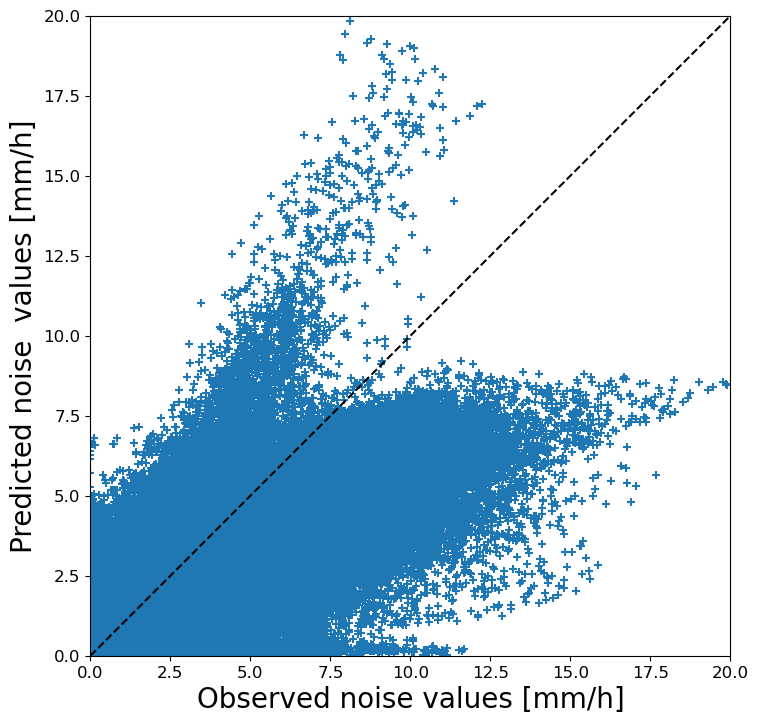

In [27]:
i=28
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#plt.scatter(df['refe'].values[:].flatten(),df['noiseP'].values[:].flatten(),marker='+')
plt.scatter(df_unet['hr'].values.flatten(),df_unet['fcst'].values.flatten(),marker='+')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
ax.plot((0, 20), (0, 20), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
ax.set_xlim([0,20])
ax.set_ylim([0,20])
ax.set_xlabel("Observed noise values [mm/h]",fontsize=20)
ax.set_ylabel("Predicted noise  values [mm/h]",fontsize=20)
figname = "diffusion"+'_scatters_harris'
#figpath = os.path.join(save_dir,figname)
#plt.savefig(figpath, bbox_inches="tight"
plt.show()

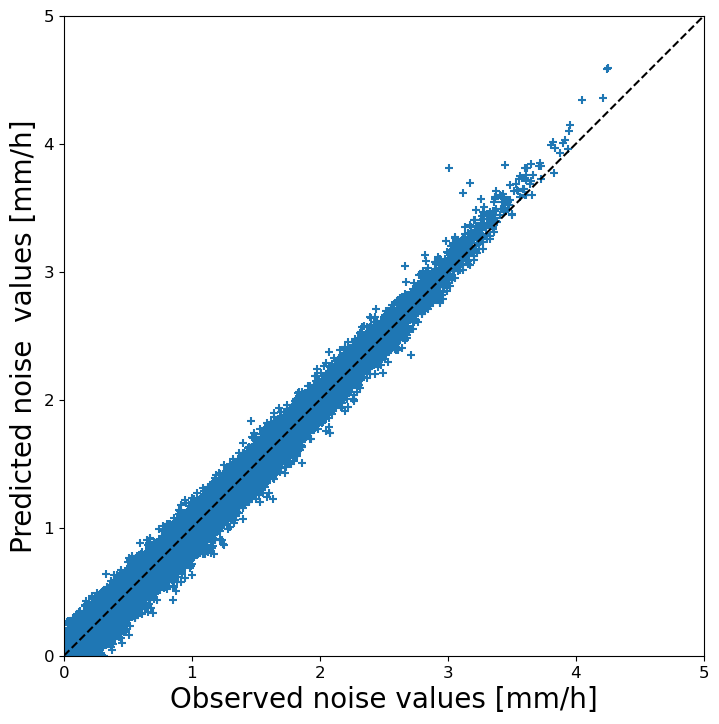

In [22]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#plt.scatter(df['refe'].values[:].flatten(),df['noiseP'].values[:].flatten(),marker='+')
plt.scatter(df_unet['noiseP'].values[:10].flatten(),df_unet['refe'].values[:10].flatten(),marker='+')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
ax.plot((0, 10), (0, 10), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_xlabel("Observed noise values [mm/h]",fontsize=20)
ax.set_ylabel("Predicted noise  values [mm/h]",fontsize=20)
figname = "diffusion"+'_scatters_095'
#figpath = os.path.join(save_dir,figname)
#plt.savefig(figpath, bbox_inches="tight"
plt.show()

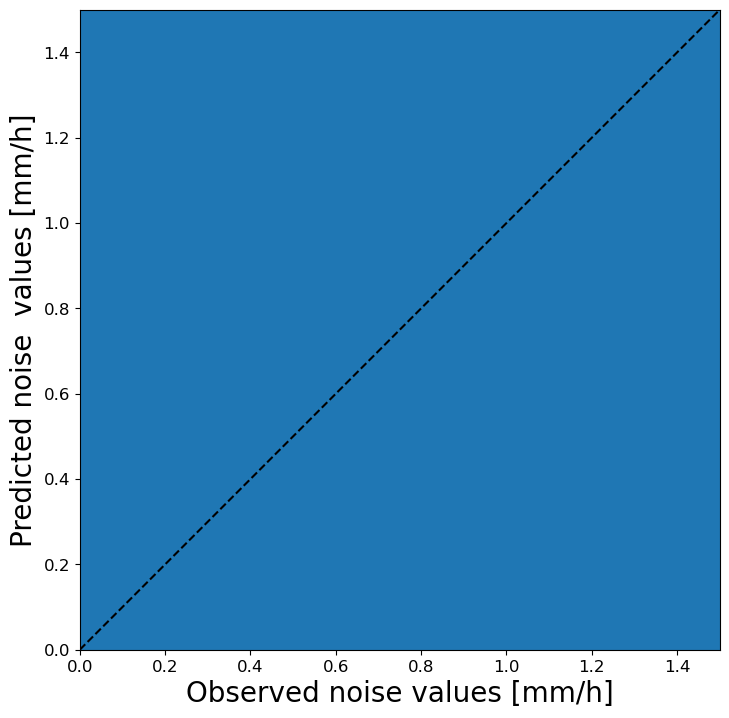

In [28]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#plt.scatter(df['refe'].values[:].flatten(),df['noiseP'].values[:].flatten(),marker='+')
plt.scatter(df_unet['hr'].values.flatten(),df_unet['fcst'].values.flatten(),marker='+')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
ax.plot((0, 1.5), (0, 1.5), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
ax.set_xlim([0,1.5])
ax.set_ylim([0,1.5])
ax.set_xlabel("Observed noise values [mm/h]",fontsize=20)
ax.set_ylabel("Predicted noise  values [mm/h]",fontsize=20)
figname = "diffusion"+'_scatters_05'
#figpath = os.path.join(save_dir,figname)
#plt.savefig(figpath, bbox_inches="tight"
plt.show()

# Spectrum analysis

In [16]:
#diffusion models
import xarray as xr

f2_diff = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_test/prcp_downs_diffusion_7.nc"
df_diff =  xr.open_dataset(f2_diff, engine='netcdf4')
fcst_diff = df_diff['fcst'].values

f2_diff_step300 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_step300_test/prcp_downs_diffusion_7.nc"
df_diff_step300 =  xr.open_dataset(f2_diff_step300, engine='netcdf4')
fcst_diff_step300 = df_diff_step300['fcst'].values

#df_diff['fcst'].values = slope * fcst_diff  + intercept

In [3]:
f2_diff_step250 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_step250_test/prcp_downs_diffusion_7.nc"
df_diff_step250 =  xr.open_dataset(f2_diff_step250, engine='netcdf4')
fcst_diff_step250 = df_diff_step250['fcst'].values
#df_diff_step80['fcst'].values = slope * fcst_diff_step80  + intercept

In [4]:
f2_diff_step80 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_step80_test/prcp_downs_diffusion_7.nc"
df_diff_step80 =  xr.open_dataset(f2_diff_step80, engine='netcdf4')
fcst_diff_step80 = df_diff_step80['fcst'].values
#df_diff_step80['fcst'].values = slope * fcst_diff_step8

In [5]:
f2_diff_step100 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_step100_test/prcp_downs_diffusion_7.nc"
df_diff_step100 =  xr.open_dataset(f2_diff_step100, engine='netcdf4')
fcst_diff_step100 = df_diff_step100['fcst'].values

In [6]:
f2_diff_step150 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_step150_test/prcp_downs_diffusion_7.nc"
df_diff_step150 =  xr.open_dataset(f2_diff_step150, engine='netcdf4')
fcst_diff_step150 = df_diff_step150['fcst'].values

In [7]:
f2_wgan= "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test/prcp_downs_wgan_7.nc"
df_wgan =  xr.open_dataset(f2_wgan, engine='netcdf4')
fcst_wgan = df_wgan['fcst'].values

In [8]:
f2_unet = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_top_test/prcp_downs_unet_{}.nc".format(str(7))
df_unet =  xr.open_dataset(f2_unet, engine='netcdf4')
fcst_unet = df_unet['fcst'].values

In [25]:
df_diff['fcst'][j].plot(vmin=0, vmax=20)

NameError: name 'j' is not defined

In [ ]:
df_diff['hr'][j].plot(vmin=0, vmax=20)

In [ ]:
df_unet['fcst'][j].plot(vmin=0, vmax=20)

In [ ]:
df_wgan['fcst'][j].plot(vmin=0, vmax=20)

In [5]:
def abins_cal(image, npix=160):
    
    """
    image: the image input 
    npix: the pix
    """
   
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2
    kfreq = np.fft.fftfreq(npix) * 160
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return Abins, kvals


In [10]:
def cal_images(images):
    abins_all = []
    kvals_all= [] 
    for img in images:
        abins, kvals = abins_cal(img)
        abins_all.append(abins)
    abins_all_mean = np.mean(np.array(abins_all) , axis=0) 

    return abins_all_mean, kvals

In [21]:
#abins_all, kvals_all = cal_images( df_diff['fcst'].values)

# abins_all_unet, kvals_all_unet = cal_images(df_unet['fcst'].values)
# abins_all_wgan, kvals_all_wgan = cal_images(df_wgan['fcst'].values)
abins_all_hr, kvals_all_hr = cal_images(df_diff ['hr'].values)
abins_all_fcst_notop, kvals_all_fcst_notop = cal_images(df_diff ['fcst'].values)
abins_all_fcst_step80, kvals_all_fcst_step80= cal_images(df_diff_step80['fcst'].values)
#abins_all_fcst_step100, kvals_all_fcst_step100= cal_images(df_diff_step100['fcst'].values)
abins_all_fcst_step150, kvals_all_fcst_step150= cal_images(df_diff_step100['fcst'].values)
abins_all_fcst_step250, kvals_all_fcst_step250= cal_images(df_diff_step250 ['fcst'].values)
abins_all_fcst_step300, kvals_all_fcst_step300= cal_images(df_diff_step300 ['fcst'].values)

In [29]:
# Abins_fcst, kvals_fcst = abins_cal(fcst_diff )
# Abins_hr, kvals_hr = abins_cal(hr)
# Abins_unet, kvals_unet = abins_cal(fcst_unet)
# Abins_wgan, kvals_wgan = abins_cal(fcst_wgan)
# Abins_fcst_notop, kvals_fcst_notop = abins_cal(fcst_notop)

In [ ]:
len(abins_all_unet)

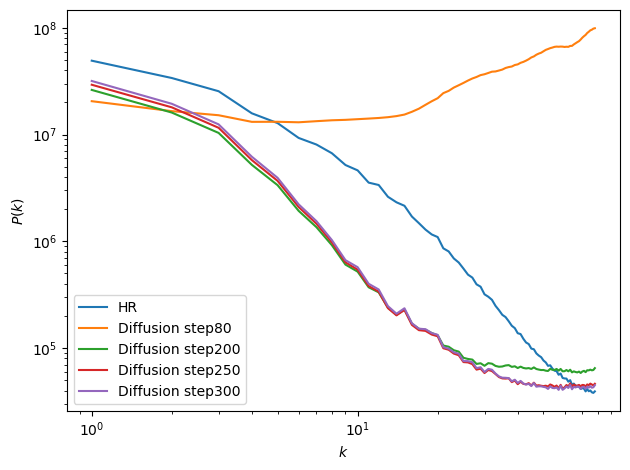

In [23]:
pl.loglog(kvals_all_hr[:78], abins_all_hr[:78], label = "HR")
pl.loglog(kvals_all_fcst_step80[:78],abins_all_fcst_step80[:78], label = "Diffusion step80")
pl.loglog(kvals_all_fcst_notop[:78], abins_all_fcst_notop[:78], label = "Diffusion step200")
# pl.loglog(kvals_all_fcst_step100[:78], abins_all_fcst_step100[:78], label = "Diffusion step100")
#pl.loglog(kvals_all_fcst_step150[:78], abins_all_fcst_step150[:78], label = "Diffusion step150")
pl.loglog(kvals_all_fcst_step250[:78], abins_all_fcst_step250[:78], label = "Diffusion step250")
pl.loglog(kvals_all_fcst_step300[:78], abins_all_fcst_step300[:78], label = "Diffusion step300")
#pl.loglog(kvals_all_wgan[:78], abins_all_wgan[:78], label = "GAN") #wwihtout topicgraph
#pl.loglog(kvals_all_unet[:78], abins_all_unet[:78], label = "U-Net") 
#pl.loglog(kvals_wgan, Abins_wgan)
pl.xlabel("$k$")
pl.ylabel("$P(k)$")
pl.tight_layout()
plt.legend()
pl.savefig("M7_diffusion_steps_cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")

In [ ]:
# Diffusion steps

In [85]:
# pl.loglog(kvals_unet, Abins_unet)
# #pl.loglog(kvals_fcst, Abins)
# pl.xlabel("$k$")
# pl.ylabel("$P(k)$")
# pl.tight_layout()
# pl.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")


## Plot the topography

In [9]:
top_file = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test/prcp_downs_wgan_4.nc"

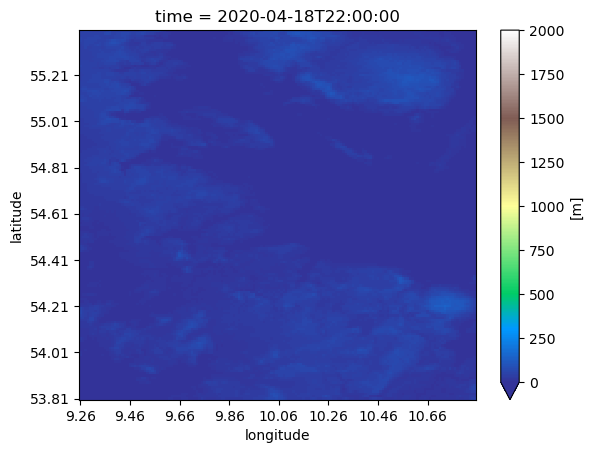

In [11]:
i=426
df_top_file =  xr.open_dataset(top_file, engine='netcdf4')
lons = df_top_file['lons'][i].values
lats =  df_top_file['lats'][i].values
pos = list(range(0,160,20))
df_top_file["tops"][i].plot(vmin=0, vmax=2000,cmap='terrain',cbar_kwargs={"label":"[m]"})
pos_hr = list(range(0,160,20))
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
plt.savefig( str(i) + "top.png")

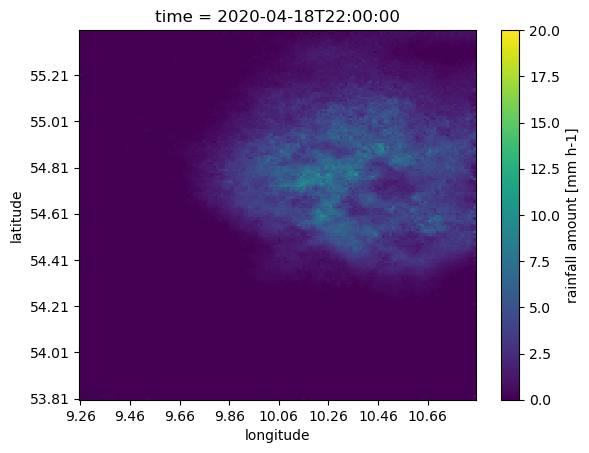

In [7]:
#file = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_top_test/prcp_downs_unet_6.nc"
i = 426
file = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_top_test_01/prcp_downs_diffusion_4.nc"
#file = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test/prcp_downs_wgan_4.nc"
df_top_file =  xr.open_dataset(file, engine='netcdf4')
lons = df_top_file ['lons'][i].values
lats =  df_top_file ['lats'][i].values
pos = list(range(0,160,20))
fcst = df_top_file['fcst'].values[i]
df_top_file["fcst"][i] =  slope * fcst + intercept
df_top_file["fcst"][i].plot(vmin=0, vmax=20,cbar_kwargs={"label":"rainfall amount [mm h-1]" })
pos_hr = list(range(0,160,20))
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.yticks(ticks = pos_hr,labels = lats[list(range(0,160,20))])
plt.xticks(ticks = pos_hr,labels = lons[list(range(0,160,20))])
plt.savefig( str(i) + "diffusion_top_fcst.png")

## Descriptive analysis of the forecasts and ground truth data

In [1]:

#save_dir = '/p/scratch/deepacf/deeprain/ji4/Downsacling/results/swinUnet_exp1019_origin_booster_3years/prediction_18000'
#save_dir = "/p/home/jusers/gong1/juwels/bing_folder/downscaling_maelstrom/results/exp_20230319_swinunet_remove_last_batch_test"
#save_dir = "/p/scratch/deepacf/deeprain/ji4/Downsacling/results/unet_exp_20230130_580000_G"
#save_dir = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20230421_epoch20_repeat2_n8_entire_domain_epoch20_results_215000"
# save_dir = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results//exp_20231010_blinear_results_debug"
# model_name = "bilinear"
# #prcp_downs_swinUnet_1.nc
# filename = 'prcp_downs_'+model_name+'_1.nc'
# filepath = os.path.join(save_dir,filename)
# with xr.open_dataset(filepath, engine="netcdf4") as df:
#     print(df)
#     fcst = np.array(df['fcst'][:])
#     refe = np.array(df['hr'][:])
#     inpt = np.array(df['inputs'][:])
#     time = np.array(df['time'][:]) 
#     lats =  np.array( df["lats"][:])
#     lons =  np.array( df["lons"][:])

In [38]:
df_sel = df.sel(time="2020-01-30T06:00:00.000000000")

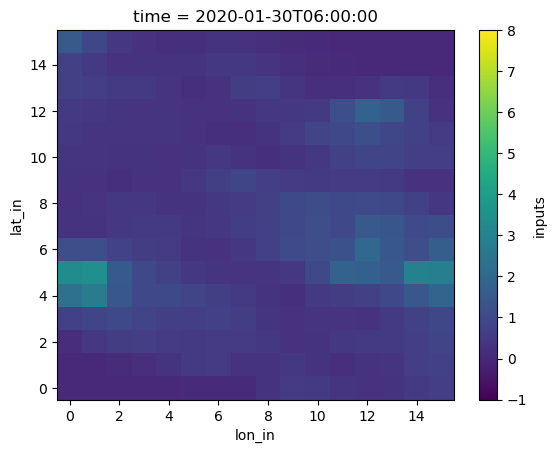

In [10]:
i= 12
df_sel['inputs'][i].plot(vmin=-1, vmax=8)

In [11]:
np.min(fcst)

6.893957e-17

In [12]:
np.max(fcst)

0.045298796

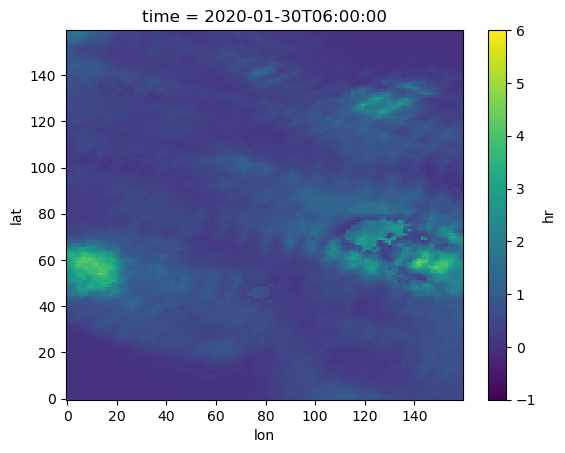

In [16]:

df_sel['hr'][i].plot(vmin=-1, vmax=6)

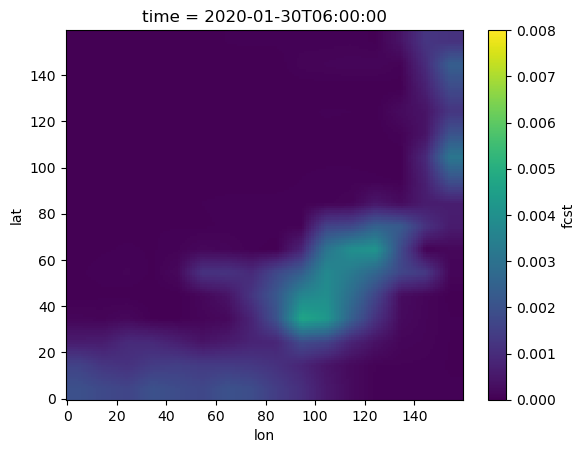

In [14]:

df_sel['fcst'][i].plot(vmin=0, vmax=0.008)

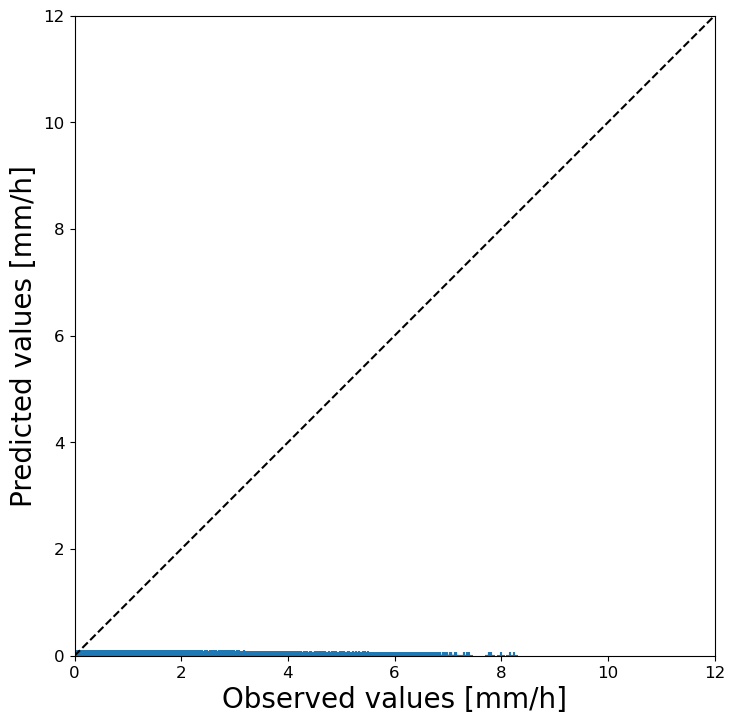

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
plt.scatter(refe[:200].flatten(),fcst[:200].flatten(),marker='+')


plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
ax.set_xlim([0,12])
ax.set_ylim([0,12])
ax.set_xlabel("Observed values [mm/h]",fontsize=20)
ax.set_ylabel("Predicted values [mm/h]",fontsize=20)
figname = model_name+'_scatters'
figpath = os.path.join(fig_dir,figname)
plt.savefig(figpath, bbox_inches="tight")
plt.show()


# WGAN

In [5]:
save_dir = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231010_wgan_results"
model_name = 'wgan'
#prcp_downs_swinUnet_1.nc
filename = 'prcp_downs_'+model_name+'_12.nc'
filepath = os.path.join(save_dir,filename)
with xr.open_dataset(filepath, engine="netcdf4") as df:
    print(df)
    fcst = np.array(df['fcst'][:])
    refe = np.array(df['hr'][:])
    inpt = np.array(df['inputs'][:])
    time = np.array(df['time'][:]) 
    lats =  np.array( df["lats"][:])
    lons =  np.array( df["lons"][:])


<xarray.Dataset>
Dimensions:    (pitch_idx: 100032, time: 65, lat: 160, lon: 160, lat_in: 16,
                lon_in: 16)
Coordinates:
  * pitch_idx  (pitch_idx) int32 93461 26074 45994 39126 ... 5457 67125 74260
  * time       (time) datetime64[ns] 2020-12-01T01:00:00 ... 2020-12-01
Dimensions without coordinates: lat, lon, lat_in, lon_in
Data variables:
    fcst       (time, lat, lon) float32 ...
    hr         (time, lat, lon) float32 ...
    lats       (time, lat) float32 ...
    lons       (time, lon) float32 ...
    inputs     (time, lat_in, lon_in) float32 ...
Attributes:
    description:  Precipitation downscaling data.


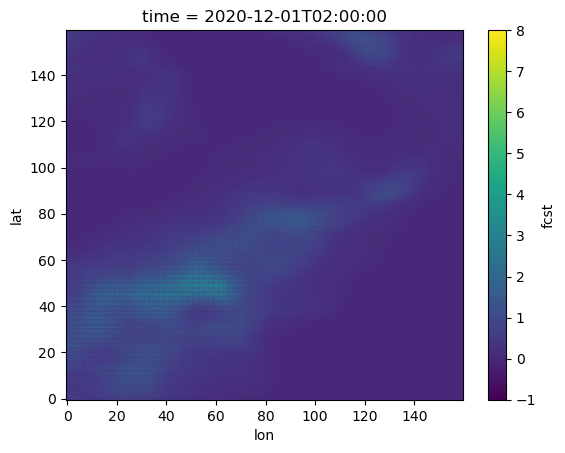

In [6]:
i= 1
df['fcst'][i].plot(vmin=-1, vmax=8)

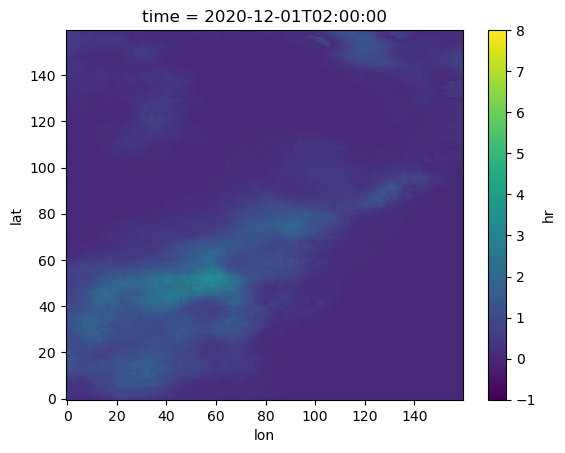

In [9]:
df['hr'][i].plot(vmin=-1, vmax=8)

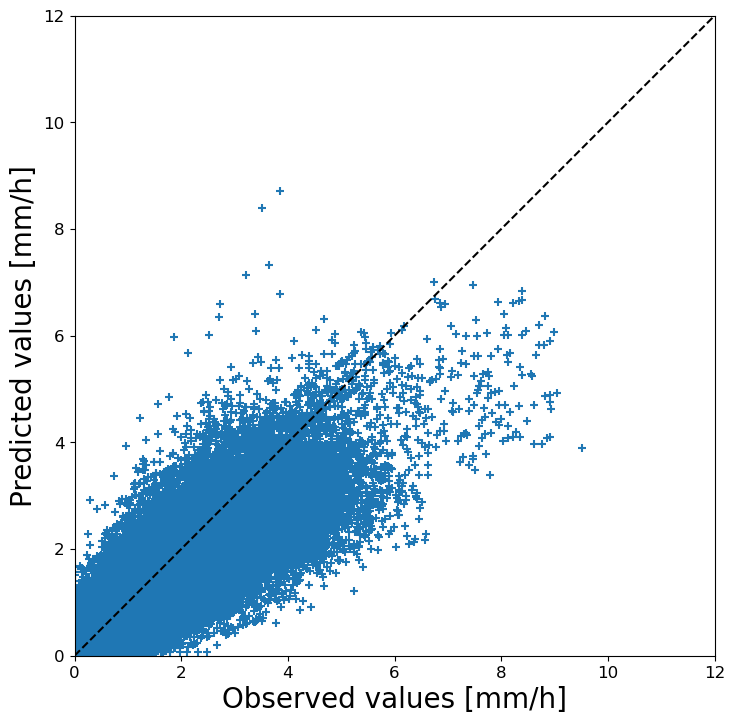

In [13]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
plt.scatter(refe[:].flatten(),fcst[:].flatten(),marker='+')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
ax.set_xlim([0,12])
ax.set_ylim([0,12])
ax.set_xlabel("Observed values [mm/h]",fontsize=20)
ax.set_ylabel("Predicted values [mm/h]",fontsize=20)
figname = model_name+'_scatters'
figpath = os.path.join(fig_dir,figname)w w w
plt.savefig(figpath, bbox_inches="tight")
plt.show()

## Calculate the evaluation metrics

In [2]:
#https://www.showdoc.com.cn/meteva/3975610088390562
#pc(ob, fo,grade_list=[1e-30],compare = “>=”):准确率 基于原始数据计算accuracy： （Hits+ Correct negatives）/Total，反映被正确预报的样本占比
#pod(ob, fo,grade_list=[1e-30],compare = “>=”)命中率(并行）又称基于原始数据计算hit rate： Hits/(Hits + Misses)，反映观测的正样本中多少被预报
#pc_of_sun_rain 晴雨准确率#基于原始数据计算accuracy： （Hits+ Correct negatives）/Total，反映被正确预报的样本占比
#pofd 报空率: 基于原始数据计算Probability of false detection： False alarms/(False alarms + Correct negatives)，反映观测负样本被预报为正样本的比例
#far 空报率:far(ob, fo,grade_list=[1e-30],compare = “>=”)基于原始数据计算False alarm ratio： False alarms/(Hit + False alarms)，反映预报的正样本中实际未发生的比例
#mr: 漏报率: mr(ob, fo,grade_list=[1e-30],compare = “>=”) 基于原始数据计算Miss ratio： Misses/(Hit + Misses)，反映观测正样本被预报为负样本的比例
#ets: ets(ob, fo,grade_list=[1e-30],compare = “>=”) 基于原始数据计算ets： (Hit-Hit_random) /(Hit + Misses+ False alarms - Hit_random)，反映预测的正样本与观察到的正样本对应的程度如何, 其中扣除了随机预报产生的命中数量，Hit_random = Forecast yes × Observed yes / Total
#fscore: fscore(ob, fo,grade_list=[1e-30],compare = “>=”,belta=1) 基于原始数据计算fscore=(1+belta^2) (pod sr)/(belta^2 sr + pod) = (1+belta^2) hit/((1+belta^2) hit + belta^2 Mis + False alarms)
#TS评分ts(ob, fo,grade_list=[1e-30],compare = “>=”) 基于原始数据计算ts： Hit /(Hit + Misses+ False alarms)，反映预测的正样本与观察到的正样本对应的程度如何

In [3]:
m = 2



f2 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test_01/prcp_downs_wgan_{}.nc".format(str(m))
df2 =  xr.open_dataset(f2, engine='netcdf4')


In [17]:
from sklearn.utils import resample

In [18]:

for m in range(2,13):
    f = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240102_epoch20_repeat2_n8_entire_domain_epoch20_top_test/prcp_downs_unet_{}.nc".format(str(m))
    df =  xr.open_dataset(f, engine='netcdf4')
    times = df["time"].values
    refe =  df["hr"].values
    fcst = df["fcst"].values
    grade_list = [0.1,5,10,15]
    rmse = []
    corr = []
    ts = []
    ets = []
    n_interation=100
    stat_rmse = []
    stat_corr = []
    stat_ts = []

    for i in range(refe.shape[0]):
        rmse.append(mem.rmse(refe[i],fcst[i]))
        corr.append(mem.corr(refe[i],fcst[i]))    
        ts.append(mem.ts(refe[i],fcst[i],grade_list=grade_list))
    rmse = np.stack(rmse)    
    corr = np.stack(corr)    
    ts = np.stack(ts)
    corr[np.where(corr>1)] = np.nan
    ts[np.where(ts>1)] = np.nan #if the devided by zero, then the ts is not able to calcualted and we force to nan value
    
    
    for n in range(n_interation):
        
        stat_rmse.append(np.mean(resample(rmse, n_samples=100)))
        stat_corr.append(np.mean(resample(corr, n_samples=100)))
        stat_ts.append(np.mean(resample(ts[:,3], n_samples=100)))
        
    data = {'RMSE':  stat_rmse,
            'CORR':  stat_corr,
            # 'PC_of_sun_rain': pc_of_sun_rain,
            # 'CSI0.1': ts[:,0],
            # 'CSI5': ts[:,1],
            'TS10': stat_ts,
            'Month': int(m),
             'Model': "UNet"
           }
    if m == 2:
        unet_all_vars = pd.DataFrame(data=data)
    else:
        frames = [unet_all_vars, pd.DataFrame(data=data)]
        unet_all_vars = pd.concat(frames)
    
        


# fss = np.ones([refe.shape[0],len(grade_list),len(half_window_size_list)])
# for k in range(refe.shape[0]):
#     for i in range(len(grade_list)):
#         for j in range(len(half_window_size_list)):
#             fss[k,i,j] = 1 - fss_middle_all[k,j,i,2].sum()/(fss_middle_all[k,j,i,0].sum()+fss_middle_all[k,j,i,1].sum())




In [24]:


for m in range(2,13):
    f = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test_01/prcp_downs_wgan_{}.nc".format(str(m))
    df =  xr.open_dataset(f, engine='netcdf4')
    times = df["time"].values
    refe =  df["hr"].values
    fcst = df["fcst"].values
    grade_list = [0.1,5,10,15]
    rmse = []
    corr = []
    ts = []
    ets = []
    n_interation=100
    stat_rmse = []
    stat_corr = []
    stat_ts = []

    for i in range(refe.shape[0]):
        rmse.append(mem.rmse(refe[i],fcst[i]))
        corr.append(mem.corr(refe[i],fcst[i]))    
        ts.append(mem.ts(refe[i],fcst[i],grade_list=grade_list))
    rmse = np.stack(rmse)    
    corr = np.stack(corr)    
    ts = np.stack(ts)
    corr[np.where(corr>1)] = np.nan
    ts[np.where(ts>1)] = np.nan #if the devided by zero, then the ts is not able to calcualted and we force to nan value
    
    
    for n in range(n_interation):
        
        stat_rmse.append(np.mean(resample(rmse, n_samples=100)))
        stat_corr.append(np.mean(resample(corr, n_samples=100)))
        stat_ts.append(np.mean(resample(ts[:,3], n_samples=100)))
        
    data = {'RMSE':  stat_rmse,
            'CORR':  stat_corr,
            # 'PC_of_sun_rain': pc_of_sun_rain,
            # 'CSI0.1': ts[:,0],
            # 'CSI5': ts[:,1],
            'TS10': stat_ts,
            'Month': int(m),
             'Model': "WGAN"
           }
    if m == 2:
        wgan_all_vars = pd.DataFrame(data=data)
    else:
        frames = [wgan_all_vars, pd.DataFrame(data=data)]
        wgan_all_vars = pd.concat(frames)
    

In [20]:
for m in range(2,13):
    f3 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20231203_diffusion_t4_newscale2_only_rain_t02_yan_zscore_05_test/prcp_downs_diffusion_{}.nc".format(str(m)) 
    #f3 = "/p/home/jusers/gong1/juwels/bing/precipitation_downscaling/results/exp_20240103_wgan_top_test_01/prcp_downs_wgan_{}.nc".format(str(i))
    df =  xr.open_dataset(f3, engine='netcdf4')
    fcst_diff = df['fcst'].values
    df['fcst'].values = slope * fcst_diff  + intercept
    refe =  df["hr"].values
    fcst = df["fcst"].values
    grade_list = [0.1,5,10,15]
    rmse = []
    corr = []
    ts = []
    ets = []
    n_interation=100
    stat_rmse = []
    stat_corr = []
    stat_ts = []

    for i in range(refe.shape[0]):
        rmse.append(mem.rmse(refe[i],fcst[i]))
        corr.append(mem.corr(refe[i],fcst[i]))    
        ts.append(mem.ts(refe[i],fcst[i],grade_list=grade_list))
    rmse = np.stack(rmse)    
    corr = np.stack(corr)    
    ts = np.stack(ts)
    corr[np.where(corr>1)] = np.nan
    ts[np.where(ts>1)] = np.nan #if the devided by zero, then the ts is not able to calcualted and we force to nan value
    
    
    for n in range(n_interation):
        
        stat_rmse.append(np.mean(resample(rmse, n_samples=100)))
        stat_corr.append(np.mean(resample(corr, n_samples=100)))
        stat_ts.append(np.mean(resample(ts[:,3], n_samples=100)))
        
    data = {'RMSE':  stat_rmse,
            'CORR':  stat_corr,
            # 'PC_of_sun_rain': pc_of_sun_rain,
            # 'CSI0.1': ts[:,0],
            # 'CSI5': ts[:,1],
            'TS10': stat_ts,
            'Month': int(m),
             'Model': "Diffusion"
           }

    if m == 2:
        diffusion_all_vars = pd.DataFrame(data=data)
    else:
        frames = [diffusion_all_vars, pd.DataFrame(data=data)]
        diffusion_all_vars = pd.concat(frames)
           
    



In [21]:
unet_all_vars 

,RMSE,CORR,TS10,Month,Model
0,0.150034,0.781930,NaN,2,UNet
1,0.185796,0.815809,NaN,2,UNet
2,0.140829,0.798590,NaN,2,UNet
3,0.143507,0.793852,NaN,2,UNet
4,0.159253,0.810724,NaN,2,UNet
...,...,...,...,...,...
95,0.166744,0.844550,NaN,12,UNet
96,0.179884,0.850876,NaN,12,UNet
97,0.168484,0.871120,NaN,12,UNet
98,0.177895,0.852756,NaN,12,UNet


In [22]:
wgan_all_vars 

,RMSE,CORR,TS10,Month,Model
0,0.281936,0.919588,NaN,2,WGAN
1,0.460412,0.944306,NaN,2,WGAN
2,0.043039,0.920438,NaN,2,WGAN
3,0.154302,0.906970,NaN,2,WGAN
4,0.044020,0.871738,NaN,2,WGAN
...,...,...,...,...,...
2662,0.031787,0.290816,NaN,11,WGAN
2663,0.035774,0.416045,NaN,11,WGAN
2664,0.169243,0.927146,NaN,11,WGAN
2665,0.096402,0.929719,NaN,11,WGAN


In [23]:
diffusion_all_vars 

,RMSE,CORR,TS10,Month,Model
0,0.325718,0.756994,NaN,2,Diffusion
1,0.291930,0.714889,NaN,2,Diffusion
2,0.251058,0.768218,NaN,2,Diffusion
3,0.341229,0.762041,NaN,2,Diffusion
4,0.317530,0.718544,NaN,2,Diffusion
...,...,...,...,...,...
95,0.391496,0.805622,NaN,12,Diffusion
96,0.412622,0.785806,NaN,12,Diffusion
97,0.354396,0.777171,NaN,12,Diffusion
98,0.311262,0.776522,NaN,12,Diffusion


In [25]:
all_vars = pd.concat([unet_all_vars,wgan_all_vars, diffusion_all_vars ])

In [ ]:

f, ax = plt.subplots(figsize=(8, 5))

sns.set_theme(style="ticks")
ax = sns.boxplot(data=all_vars, x="Month", y="RMSE",hue="Model")
# ax.axhline(y=0, color="grey", linewidth=.5)
ax.set_xlabel('Scores', fontsize=16, labelpad=8)
ax.set_ylim([0,2])
# ax.set_ylabel('Continuous Ranked Probability Score', fontsize=14, labelpad=6)
# ax.xaxis.grid(False)
# ax.yaxis.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(trim=True, left=True)
# plt.legend(title = "Model", 
#            fontsize = '10', title_fontsize = "10",
#            loc = 2, bbox_to_anchor = (1.01,0.7))
# plt.savefig(fig_path, bbox_inches="tight")
plt.show()
plt.close()

## Besides the evlation metrics above, we also folllow the study from [Leinonen 2020](https://arxiv.org/abs/2005.10374) to use the log spectral distance (LSD) metrics

In [2]:
#Reference how to calculate the power spectra https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/


In [9]:
torch_fcst = torch.tensor(fcst).view(fcst.shape[0],-1,fcst.shape[1],fcst.shape[2])
torch_refe = torch.tensor(refe).view(fcst.shape[0],-1,fcst.shape[1],fcst.shape[2])
ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=6,kernel_size=7)

In [21]:
ms_ssim(torch_fcst, torch_refe)

tensor(nan)

tensor(nan)

tensor(nan)

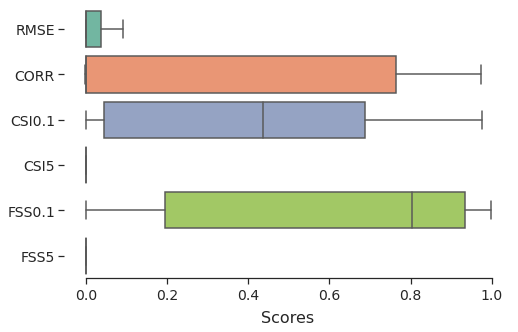

In [30]:
# create colormaps
clevs = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750])*1e-2
label = 'Precipitation Rate [mm/hour]'
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),`
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]

cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
cmap.set_bad(color='grey')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

## Plot the ground truth and prediction

In [50]:
config

{'epochs': 2}